# 0. Getting started

### System

#### Windows

|                |                                                   |
|----------------|---------------------------------------------------|
| Выпуск         | Windows 10 Pro                                    |
| Версия         | 22H2                                              |
| Дата установки | 18.09.2020                                        |
| Сборка ОС      | 19045.3570                                        |
| Взаимодействие | Windows Feature Experience Pack 1000.19052.1000.0 |

#### WSL2

|                |         |         |
|----------------|---------|---------|
|   NAME         | STATE   | VERSION |
| * Ubuntu-20.04 | Running | 2       |

##### Ubuntu

|                |                    |
|----------------|--------------------|
| Distributor ID | Ubuntu             |
| Description    | Ubuntu 22.04.3 LTS |
| Release        | 22.04              |
| Codename       | jammy              |

##### mamba

|           |        |
|-----------|--------|
| **mamba** | 1.4.2  |
| **conda** | 23.3.1 |

### Tips

Jupyter notebook:  
*   `%%bash` - выполнить команды в `bash`;
*   `%%file name.txt` - записать содержимое ячейки в файл `name.txt`.

Bash:
*   `path_to_dir=$(pwd)`  # Записать в переменную результат выполнения команды `pwd`  
                        # Важно: не `path`! Зарезервирована под переменные окружения  
                        # Можно подставлять, если программа требует абсолютный адрес:  
*   `fastqc -o . $path_to_dir/example.fastq.gz`

### Create working directory

In [ ]:
%%bash
cd /mnt/f/Documents/Bioinformatics_Institute/Semester_project
mkdir -p code/scripts
mkdir -p data_folder/raw_data && mkdir -p data_folder/processed_data && mkdir -p data_folder/imgs

mkdir programms

### Create virtual enviroment

In [ ]:
%%bash
mamba create -n stas_project python=3.10
mamba activate stas_project

In [ ]:
%%cmd  # Windows 10 Pro 22H2, Miniforge3-23.3.1-1.4.2., Miniforge Prompt

mamba create -n stas_project python=3.10
mamba activate stas_project

### Install tools

In [ ]:
%%bash
mamba install -c bioconda fastqc
fastqc --version
# FastQC v0.12.1

mamba install -c bioconda trimmomatic
trimmomatic -version
# 0.39

mamba install -c bioconda bwa
bwa
# Program: bwa (alignment via Burrows-Wheeler transformation)
# Version: 0.7.17-r1188

mamba install -c bioconda samtools
samtools --version
# samtools 1.18
# Using htslib 1.18

mamba install -c bioconda snakemake
snakemake --version
# 7.32.4

# manual installation
git clone https://github.com/pachterlab/kallisto.git
apt-get install autoconf
cd kallisto && mkdir build && cd build && cmake .. && make # https://pachterlab.github.io/kallisto/source
mv kallisto programms/kallisto
programms/kallisto/build/src/kallisto version
# kallisto, version 0.50.1
## bioconda installation
## mamba install bioconda::kallisto  # mamba install -c bioconda kallisto
## kallisto version
## # kallisto, version 0.50.1

mamba install transdecoder -c bioconda

In [217]:
%%bash
pip list --format=freeze > requirements_unix.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
%%cmd  # Windows 10 Pro 22H2, Miniforge3-23.3.1-1.4.2., Miniforge Prompt

mamba install numpy -c bioconda 
mamba install pandas -c bioconda  # рекомендуется для `rpy2`
mamba install fastcluster
mamba install rpy2 -c bioconda

mamba install matplotlib -c bioconda
mamba install seaborn -c bioconda

mamba update biopython
pip show biopython
# Name: biopython
# Version: 1.83

In [216]:
!pip list --format=freeze > requirements_win.txt

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import fastcluster
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
%load_ext rpy2.ipython
import seaborn as sns
import shutil

from Bio import (Entrez, SeqIO)
from IPython.display import Image
from math import log

from scripts.EDA import run_eda
from scripts.OpenFasta import FastaRecord, OpenFasta

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
if (!require("BiocManager", quietly = TRUE))
    suppressWarnings(suppressMessages(install.packages("BiocManager")))

R[write to console]: Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.2 (2023-10-31 ucrt)



In [ ]:
%%R
BiocManager::install("DESeq2")
install.packages("dplyr")
install.packages("gplots")

In [ ]:
%%R
library("DESeq2")
library("dplyr")
library("gplots")

# 1. Baisc workflow

##  0. unzip fastq.bz2 files

Otherwise `fastq` will work *very* slow

In [ ]:
%%bash
bzip2 -vcfdk data_folder/raw_data/reads/Primary_polyp_AZK_1_GAGTGGAT_L002_R1_001.fastq.bz2 > data_folder/raw_data/reads/reads-1.fastq
bzip2 -vcfdk data_folder/raw_data/reads/Primary_polyp_AZK_2_ACTGATAT_L002_R1_001.fastq.bz2 > data_folder/raw_data/reads/reads-2.fastq
bzip2 -vcfdk data_folder/raw_data/reads/Primary_polyp_AZK_3_ATTCCTTT_L002_R1_001.fastq.bz2 > data_folder/raw_data/reads/reads-3.fastq

head data_folder/raw_data/reads/reads-1.fastq
head data_folder/raw_data/reads/reads-2.fastq
head data_folder/raw_data/reads/reads-3.fastq

In [3]:
with open('../data_folder/raw_data/reads/reads-1.fastq', mode='r') as reads_1:
    for n_line in range(4):
        line = reads_1.readline().strip()
        print(line)
        if n_line == 1:
            read_length = len(line)
    print()
    print(f'Read length = {read_length} b.p.')

@A00835:311:HH32MDRXY:2:2101:1235:1000 1:N:0:GAGTGGAT
NTGTTACGCGAAGAGAGGATGTCGCAATAGTCCGTTTGATTTGGTTCAAGCAAATGTTCTTCTTGGTATAAATCGGAGAACTTATGTGGAGGCGCAACAA
+
#FFFFFFFFFFFF:FFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFF::FFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFFFFFFFFFFFFFF

Read length = 100 b.p.


In [ ]:
%%bash
bzip2 -vcfdk data_folder/raw_data/control/Primary_polyp_DMSO_1_GTGGCCTT_L002_R1_001.fastq.bz2 > data_folder/raw_data/control/control-1.fastq
bzip2 -vcfdk data_folder/raw_data/control/Primary_polyp_DMSO_2_GTGGCCTT_L002_R1_001.fastq.bz2 > data_folder/raw_data/control/control-2.fastq
bzip2 -vcfdk data_folder/raw_data/control/Primary_polyp_DMSO_3_GTGGCCTT_L002_R1_001.fastq.bz2 > data_folder/raw_data/control/control-3.fastq

head data_folder/raw_data/control/control-1.fastq
head data_folder/raw_data/control/control-2.fastq
head data_folder/raw_data/control/control-3.fastq

In [4]:
with open('../data_folder/raw_data/control/control-1.fastq', mode='r') as control_1:
    for n_line in range(4):
        line = control_1.readline().strip()
        print(line)
        if n_line == 1:
            read_length = len(line)
    print()
    print(f'Read length = {read_length} b.p.')

@A00835:311:HH32MDRXY:2:2101:1217:1000 1:N:0:GTGGCCTT
NCCATTCTTTCGACGTTCAACATATTCCTCACGATCCCAACGTGTGAATCCCCATTTCTTGGAAACGAAGATCTTTTGACGACCAGGGAACTTGAATTTA
+
#FFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFF:FFFFFFFFFFFFFF::FFFFF

Read length = 100 b.p.


Base in first position of *n* first reads is *N*. This is [because](https://dnatech.genomecenter.ucdavis.edu/faqs/my-fastq-file-contains-ns-is-there-a-problem-with-my-data/) first few thousand reads are of comparatively low quality and frequently Illumina software was not able to make a basecall for number of bases.

##  1. Inspect reads with FastQC

In [ ]:
%%bash
fastqc -o data_folder/processed_data/1.QC/fastqc/reads/ -t 16 data_folder/raw_data/reads/reads-1.fastq
fastqc -o data_folder/processed_data/1.QC/fastqc/reads/ -t 16 data_folder/raw_data/reads/reads-2.fastq
fastqc -o data_folder/processed_data/1.QC/fastqc/reads/ -t 16 data_folder/raw_data/reads/reads-3.fastq

## 2. TIN (Transcript Integrity Number)

pass

##  3. Alignment

[How](https://stepik.org/lesson/781360/step/2?unit=783964) to count coverage for each gene.

## 4. Expression count

##### RSEM

##### kallisto

In [5]:
%%bash
read_len=$(head data_folder/raw_data/reads/reads-1.fastq | sed -n '2p' | tr -d '\n' | wc -m)
echo "${read_len}"

100


In [ ]:
%%bash
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/read_1
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/read_2
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/read_3

mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/control_1
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/control_2
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/control_3

read_len=$(head data_folder/raw_data/reads/reads-1.fastq | sed -n '2p' | tr -d '\n' | wc -m) && echo "${read_len}"  # сохраним длину ридов для флага `-l` у kallisto

programms/kallisto/build/src/kallisto index -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta &> data_folder/processed_data/4.Expression_count/kallisto/kallisto_index_log.txt

programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/read_1 --single -l $read_len -s 1 data_folder/raw_data/reads/reads-1.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/read_1/kallisto_quant_log.txt
programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/read_2 --single -l $read_len -s 1 data_folder/raw_data/reads/reads-2.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/read_2/kallisto_quant_log.txt
programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/read_3 --single -l $read_len -s 1 data_folder/raw_data/reads/reads-3.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/read_3/kallisto_quant_log.txt

programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/control_1 --single -l $read_len -s 1 data_folder/raw_data/control/control-1.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/control_1/kallisto_quant_log.txt
programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/control_2 --single -l $read_len -s 1 data_folder/raw_data/control/control-2.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/control_2/kallisto_quant_log.txt
programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/control_3 --single -l $read_len -s 1 data_folder/raw_data/control/control-3.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/control_3/kallisto_quant_log.txt


In [6]:
with open('../data_folder/raw_data/reads/reads-1.fastq') as read1:
    for _ in range(4):
        print(read1.readline())

@A00835:311:HH32MDRXY:2:2101:1235:1000 1:N:0:GAGTGGAT

NTGTTACGCGAAGAGAGGATGTCGCAATAGTCCGTTTGATTTGGTTCAAGCAAATGTTCTTCTTGGTATAAATCGGAGAACTTATGTGGAGGCGCAACAA

+

#FFFFFFFFFFFF:FFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFF::FFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFFFFFFFFFFFFFF



In [3]:
kallisto_res = []
for sp_num in range(1, 4):
    kallisto_res.append(pd.read_table(f'../data_folder/processed_data/4.Expression_count/kallisto/results/control_{sp_num}/abundance.tsv', header = 0, index_col=0).tpm)
for sp_num in range(1, 4):
    kallisto_res.append(pd.read_table(f'../data_folder/processed_data/4.Expression_count/kallisto/results/read_{sp_num}/abundance.tsv', header = 0, index_col=0).tpm)

kallisto_indices = [set(idx.index) for idx in kallisto_res]
print(set.difference(*kallisto_indices))

kallisto_matrix = pd.DataFrame(list(zip(*kallisto_res)), columns=['Primary_polyp_DMSO_1', 'Primary_polyp_DMSO_2', 'Primary_polyp_DMSO_3', 'Primary_polyp_AZK_1', 'Primary_polyp_AZK_2', 'Primary_polyp_AZK_3'], index=kallisto_res[0].index).astype('int64')
kallisto_matrix_float = pd.DataFrame(list(zip(*kallisto_res)), columns=['Primary_polyp_DMSO_1', 'Primary_polyp_DMSO_2', 'Primary_polyp_DMSO_3', 'Primary_polyp_AZK_1', 'Primary_polyp_AZK_2', 'Primary_polyp_AZK_3'], index=kallisto_res[0].index)
kallisto_matrix.head(10)

set()


,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
target_id,,,,,,
NODE_1_length_31971_cov_229.798735_g0_i0,5,6,6,8,8,9
NODE_2_length_27343_cov_160.303480_g1_i0,0,0,0,0,0,0
NODE_3_length_26347_cov_196.774065_g1_i1,0,0,0,0,0,0
NODE_4_length_25330_cov_262.211136_g2_i0,0,0,0,0,0,0
NODE_5_length_25321_cov_263.386265_g2_i1,0,0,0,1,1,1
NODE_6_length_25246_cov_137.539618_g3_i0,0,0,0,0,0,0
NODE_7_length_25135_cov_164.474135_g4_i0,0,0,0,2,1,1
NODE_8_length_24879_cov_139.783178_g3_i1,0,0,0,2,2,2
NODE_9_length_24879_cov_138.953455_g3_i2,0,0,0,0,0,0


In [8]:
kallisto_matrix.to_csv('../data_folder/processed_data/4.Expression_count/kallisto/count_martix.txt', sep='\t')

Hi there, fellow researcher.

Dataframe consists of 6 variables and 123445 observations

Following variables can be classified as string-type: ()
Following variables can be classified as number-type: ('Primary_polyp_DMSO_1', 'Primary_polyp_DMSO_2', 'Primary_polyp_DMSO_3', 'Primary_polyp_AZK_1', 'Primary_polyp_AZK_2', 'Primary_polyp_AZK_3')
Following variables can be classified as factor-type: ()
Criteria are unique values count (lower than 35 is factor) and then data type ("int64"/"float64" is number, "object" is string).

1) Basic statistics for factor-type variables.

No factor-type variables.

2) Basic statistics for numeric variables.


,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
count,"123,445.00","123,445.00","123,445.00","123,445.00","123,445.00","123,445.00"
mean,7.92,7.92,7.93,7.90,7.90,7.89
std,240.83,238.85,242.73,237.13,232.93,229.94
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00
max,"29,048.00","29,603.00","31,150.00","41,136.00","36,950.00","37,115.00"
n_outliers,"123,445.00","123,445.00","123,445.00","123,445.00","123,445.00","123,445.00"
n_unique,595.00,586.00,585.00,610.00,604.00,607.00


Numeric variables visualization:


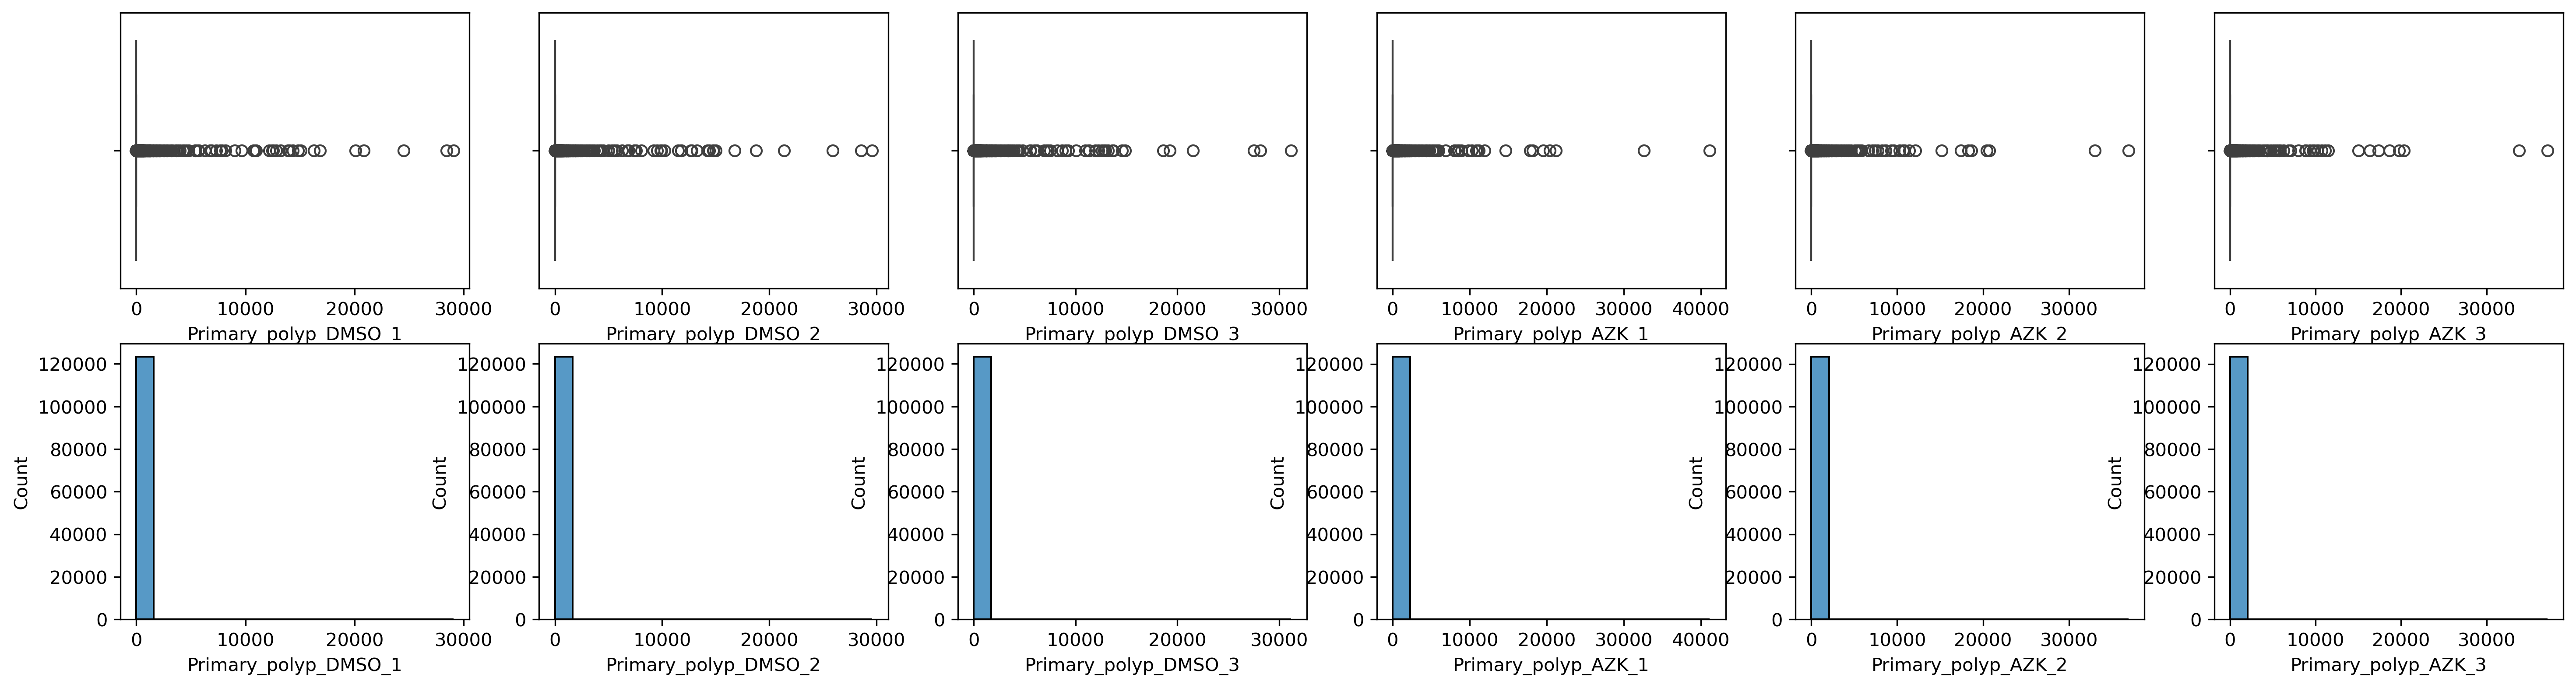

3) NA values:
- Total NA count is 0 in 0 rows.
- Following columns contain NA: ()

Dataframe contains 110817 duplicates.


f:\Documents\Bioinformatics Institute\Semester_project\code_\EDA.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


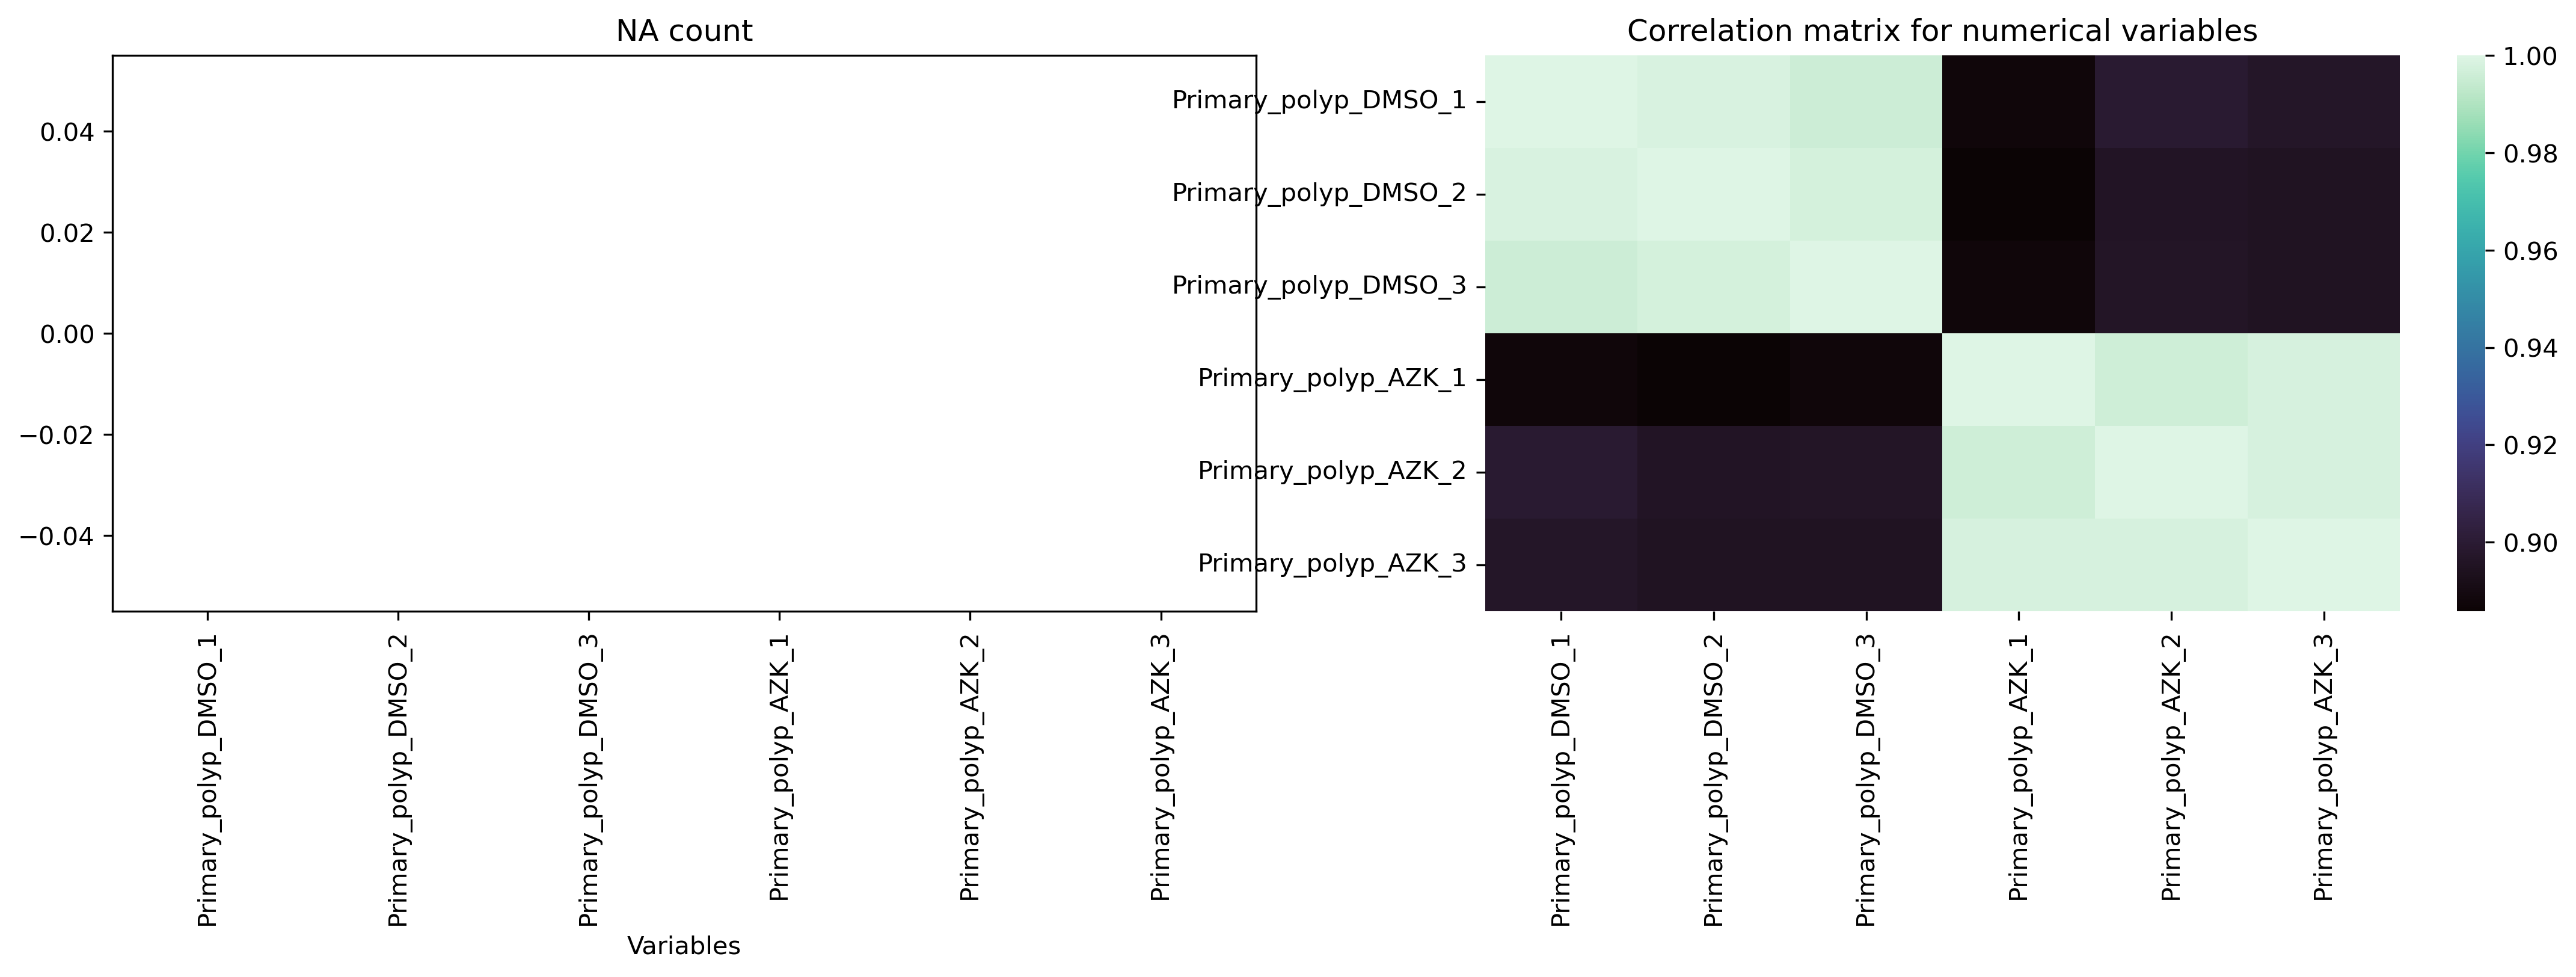

In [5]:
run_eda(kallisto_matrix)

##  5. Differential expression analysis

*   `DESeq2`
*   `EdgeR`
*   `sleuth`

[Отличия](https://www.biostars.org/p/285633/) `sleuth` от `DESeq2`.

### DESeq2

In [ ]:
%%bash
mkdir -p data_folder/processed_data/4.Expression_count/DESeq2/

#### Select control genes for DESeq

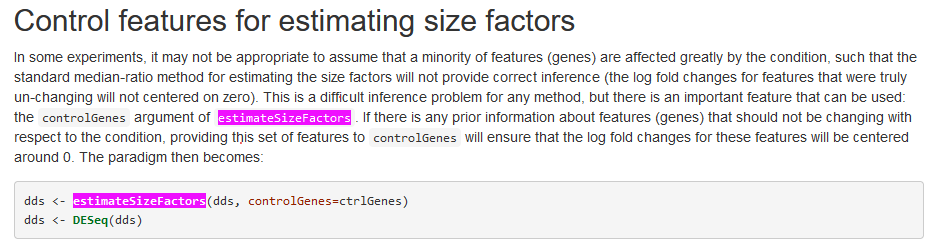

In [5]:
Image('../data_folder/processed_data/4.Expression_count/DESeq2/normalization_DESeq2_control_genes.png')  # https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#differential-expression-analysis

##### Query GAPDH sequence

In [4]:
Entrez.email = 'd2707bredov@gmail.com'

In [5]:
gapdh_name = 'Dynamena pumila glyceraldehyde 3-phosphate dehydrogenase'
handle = Entrez.esearch(db='nucleotide', term=gapdh_name)
stream = Entrez.efetch(db='nucleotide', id=Entrez.read(handle)['IdList'][0], retmode='text', rettype='gb')
gapdh_record = SeqIO.read(stream, "genbank")
stream.close()

In [6]:
gapdh_record

SeqRecord(seq=Seq('AAAGATAAAAATGGTGAAAATAGGTATTAACGGATTTGGCCGTATTGGAAGATT...AAA'), id='MK005879.1', name='MK005879', description='Dynamena pumila glyceraldehyde 3-phosphate dehydrogenase mRNA, partial cds', dbxrefs=[])

In [115]:
with open('../data_folder/raw_data/GAPDH.fasta', mode='w+') as control_genes_fasta:
    control_genes_fasta.write(f'>{gapdh_record.id} {gapdh_record.description}\n')
    control_genes_fasta.write(f'{gapdh_record.seq}\n')
    control_genes_fasta.write('\n')

##### Align to reference

In [ ]:
%%bash
cd data_folder/processed_data/bwa_res
bwa index ../../raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta
bwa mem -a -t 8 ../../raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta ../../raw_data/GAPDH.fasta 2> alignment.log | samtools view -S -b - | tee alignment_unsorted.bam | samtools flagstat - &> samtools.log

samtools sort alignment_unsorted.bam -o alignment_sorted.bam
samtools index alignment_sorted.bam

In [132]:
%%bash
samtools view ../data_folder/processed_data/bwa_res/alignment_sorted.bam | cut -f3 > ../data_folder/processed_data/bwa_res/GAPDH_nodes.txt

In [7]:
with open('../data_folder/processed_data/bwa_res/GAPDH_nodes.txt') as gapdh_nodes_file:
    gapdh_nodes = [node.strip() for node in gapdh_nodes_file.readlines()]
kallisto_matrix.loc[gapdh_nodes,:]

,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
target_id,,,,,,
NODE_7862_length_4572_cov_282.519099_g1855_i0,6,6,4,5,6,6
NODE_27786_length_2344_cov_497.751412_g1855_i2,0,0,0,0,0,0
NODE_28546_length_2298_cov_511.724169_g1855_i3,0,0,0,0,0,0
NODE_33787_length_1995_cov_585.320697_g1855_i4,0,0,0,0,0,0
NODE_34592_length_1952_cov_597.286014_g1855_i5,0,0,0,0,0,0
NODE_34790_length_1941_cov_602.326660_g1855_i6,5,3,4,1,0,3
NODE_35809_length_1886_cov_615.371677_g1855_i7,201,219,203,85,88,92


##### Save sequencies to file

In [8]:
gapdh_records = []
with OpenFasta('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta') as gene_extractor:
    for gene in gene_extractor:
        if gene.rec_id in gapdh_nodes:
            gapdh_records.append(gene)
        if len(gapdh_records) == len(gapdh_nodes):
            break

In [160]:
with open('../data_folder/processed_data/control_genes_fasta.fasta', mode='w+') as control_genes_fasta:
    for record in gapdh_records:
        control_genes_fasta.write(f'>{record.rec_id} {record.rec_desc}\n')
        control_genes_fasta.write(f'{record.rec_seq}\n')
        control_genes_fasta.write('\n')
    control_genes_fasta.write(f'>{gapdh_record.id} {gapdh_record.description}\n')
    control_genes_fasta.write(f'{gapdh_record.seq}\n')
    control_genes_fasta.write('\n')

#### Run DESeq

In [144]:
%%R
deseq2_workflow_ctrl <- function(file){
    # Set up the conditions based on the experimental setup.
    cond_1 = rep("DMSO", 3)
    cond_2 = rep("AZK", 3)

    # Read the data from the standard input.
    countData = read.table(file, header=TRUE, sep="\t", row.names=1)

    # Build the dataframe from the conditions
    samples = names(countData)
    condition = factor(c(cond_1, cond_2))
    colData = data.frame(samples=samples, condition=condition)

    # Create DESEq2 dataset.
    dds = DESeqDataSetFromMatrix(countData=countData, colData=colData, design = ~condition)

    #Set the reference to be compared
    dds$condition = relevel(dds$condition,"DMSO")

    # # Control features for estimating size factors (normalize counts)
    ctrlGenes <- c(which(rownames(countData) == "NODE_35809_length_1886_cov_615.371677_g1855_i7"))
    dds <- estimateSizeFactors(dds, controlGenes=ctrlGenes)

    # Run deseq
    dds = DESeq(dds)

    # Format the results.
    res = results(dds)

    # Sort the results data frame by the padj and foldChange columns.
    sorted = res[with(res, order(padj, -log2FoldChange)), ]

    # Turn it into a dataframe to have proper column names.
    sorted.df = data.frame("id"=rownames(sorted),sorted)

    # Write the table out.
    write.table(sorted.df, file="../data_folder/processed_data/4.Expression_count/DESeq2/result_ctrl.txt", sep="\t", col.names=NA, quote=FALSE)

    # Get normalized counts and write this to a file
    nc = counts(dds,normalized=TRUE)

    # Turn it into a dataframe to have proper column names.
    dt = data.frame("id"=rownames(nc),nc)

    # Save the normalize data matrix.
    write.table(dt, file="../data_folder/processed_data/4.Expression_count/DESeq2/norm-matrix-deseq2_ctrl.txt", sep="\t",  row.name=FALSE, col.names=TRUE,quote=FALSE)
}

#### Save results

In [145]:
%%R
file <- "../data_folder/processed_data/4.Expression_count/kallisto/count_martix.txt"
deseq2_workflow_ctrl(file)

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates



R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



#### Take a look at results

In [4]:
deseq_results_file = '../data_folder/processed_data/4.Expression_count/DESeq2/result_ctrl.txt'

In [5]:
deseq_results_ctrl = pd.read_table(deseq_results_file, header = 0, sep='\t', index_col=0)

In [6]:
deseq_results_ctrl.head()

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_61938_length_821_cov_78.356041_g20323_i0,NODE_61938_length_821_cov_78.356041_g20323_i0,"1,174.99",4.72,0.12,37.93,0.00,0.00
NODE_54812_length_1061_cov_16.372299_g16298_i0,NODE_54812_length_1061_cov_16.372299_g16298_i0,"2,100.13",2.69,0.09,29.83,0.00,0.00
NODE_67158_length_672_cov_9.523052_g24107_i0,NODE_67158_length_672_cov_9.523052_g24107_i0,"1,832.80",2.73,0.10,28.06,0.00,0.00
NODE_60533_length_865_cov_411.037713_g19428_i0,NODE_60533_length_865_cov_411.037713_g19428_i0,"8,159.71",2.25,0.08,27.66,0.00,0.00
NODE_76400_length_474_cov_168.814385_g32489_i0,NODE_76400_length_474_cov_168.814385_g32489_i0,"3,121.43",2.35,0.09,26.57,0.00,0.00


In [12]:
deseq_results_ctrl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123445 entries, NODE_61938_length_821_cov_78.356041_g20323_i0 to NODE_123445_length_144_cov_13.989305_g79464_i0
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              123445 non-null  object 
 1   baseMean        123445 non-null  float64
 2   log2FoldChange  32313 non-null   float64
 3   lfcSE           32313 non-null   float64
 4   stat            32313 non-null   float64
 5   pvalue          32311 non-null   float64
 6   padj            16308 non-null   float64
dtypes: float64(6), object(1)
memory usage: 7.5+ MB


Check for `NA`:

In [13]:
deseq_results_ctrl.query('padj < 0.05').info()

<class 'pandas.core.frame.DataFrame'>
Index: 5196 entries, NODE_61938_length_821_cov_78.356041_g20323_i0 to NODE_53553_length_1107_cov_335.498120_g15137_i1
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5196 non-null   object 
 1   baseMean        5196 non-null   float64
 2   log2FoldChange  5196 non-null   float64
 3   lfcSE           5196 non-null   float64
 4   stat            5196 non-null   float64
 5   pvalue          5196 non-null   float64
 6   padj            5196 non-null   float64
dtypes: float64(6), object(1)
memory usage: 324.8+ KB


Thus, we got $123445$ differentially expressed genes, $5196$ of them have adjusted p-value lesser than $0.05$.

In [14]:
all(deseq_results_ctrl.query('padj < 0.05').index == deseq_results_ctrl.head(5196).index)

True

##### Draw volcano plot

In [ ]:
volcano_deseq = pd.read_table(deseq_results_file, header = 0, sep='\t', index_col=0).drop(columns=['id', 'baseMean', 'lfcSE', 'stat', 'pvalue'])
volcano_deseq.head(5)

,log2FoldChange,padj
NODE_61938_length_821_cov_78.356041_g20323_i0,4.72,0.00
NODE_54812_length_1061_cov_16.372299_g16298_i0,2.69,0.00
NODE_67158_length_672_cov_9.523052_g24107_i0,2.73,0.00
NODE_60533_length_865_cov_411.037713_g19428_i0,2.25,0.00
NODE_76400_length_474_cov_168.814385_g32489_i0,2.35,0.00


In [ ]:
def expression_change(row):
    significance_type = {
        (True, False): 'Significantly upregulated',
        (True, True): 'Non-significantly upregulated',
        (False, False): 'Significantly downregulated',
        (False, True): 'Non-significantly downregulated',
        }
    significance = row.log2FoldChange >= 0, row.padj > 0.05
    return significance_type[significance]   

palette = {'Significantly upregulated': 'tab:orange',
           'Significantly downregulated': 'tab:blue',
           'Non-significantly upregulated': 'tab:red',
           'Non-significantly downregulated': 'tab:green'
           }

In [ ]:
volcano_deseq['log_padj'] = volcano_deseq.padj.apply(lambda padj: -log(padj, 10) if padj != 0 else np.nan)
volcano_deseq['expression_change'] = volcano_deseq.apply(expression_change, axis=1)
volcano_deseq = volcano_deseq.dropna()

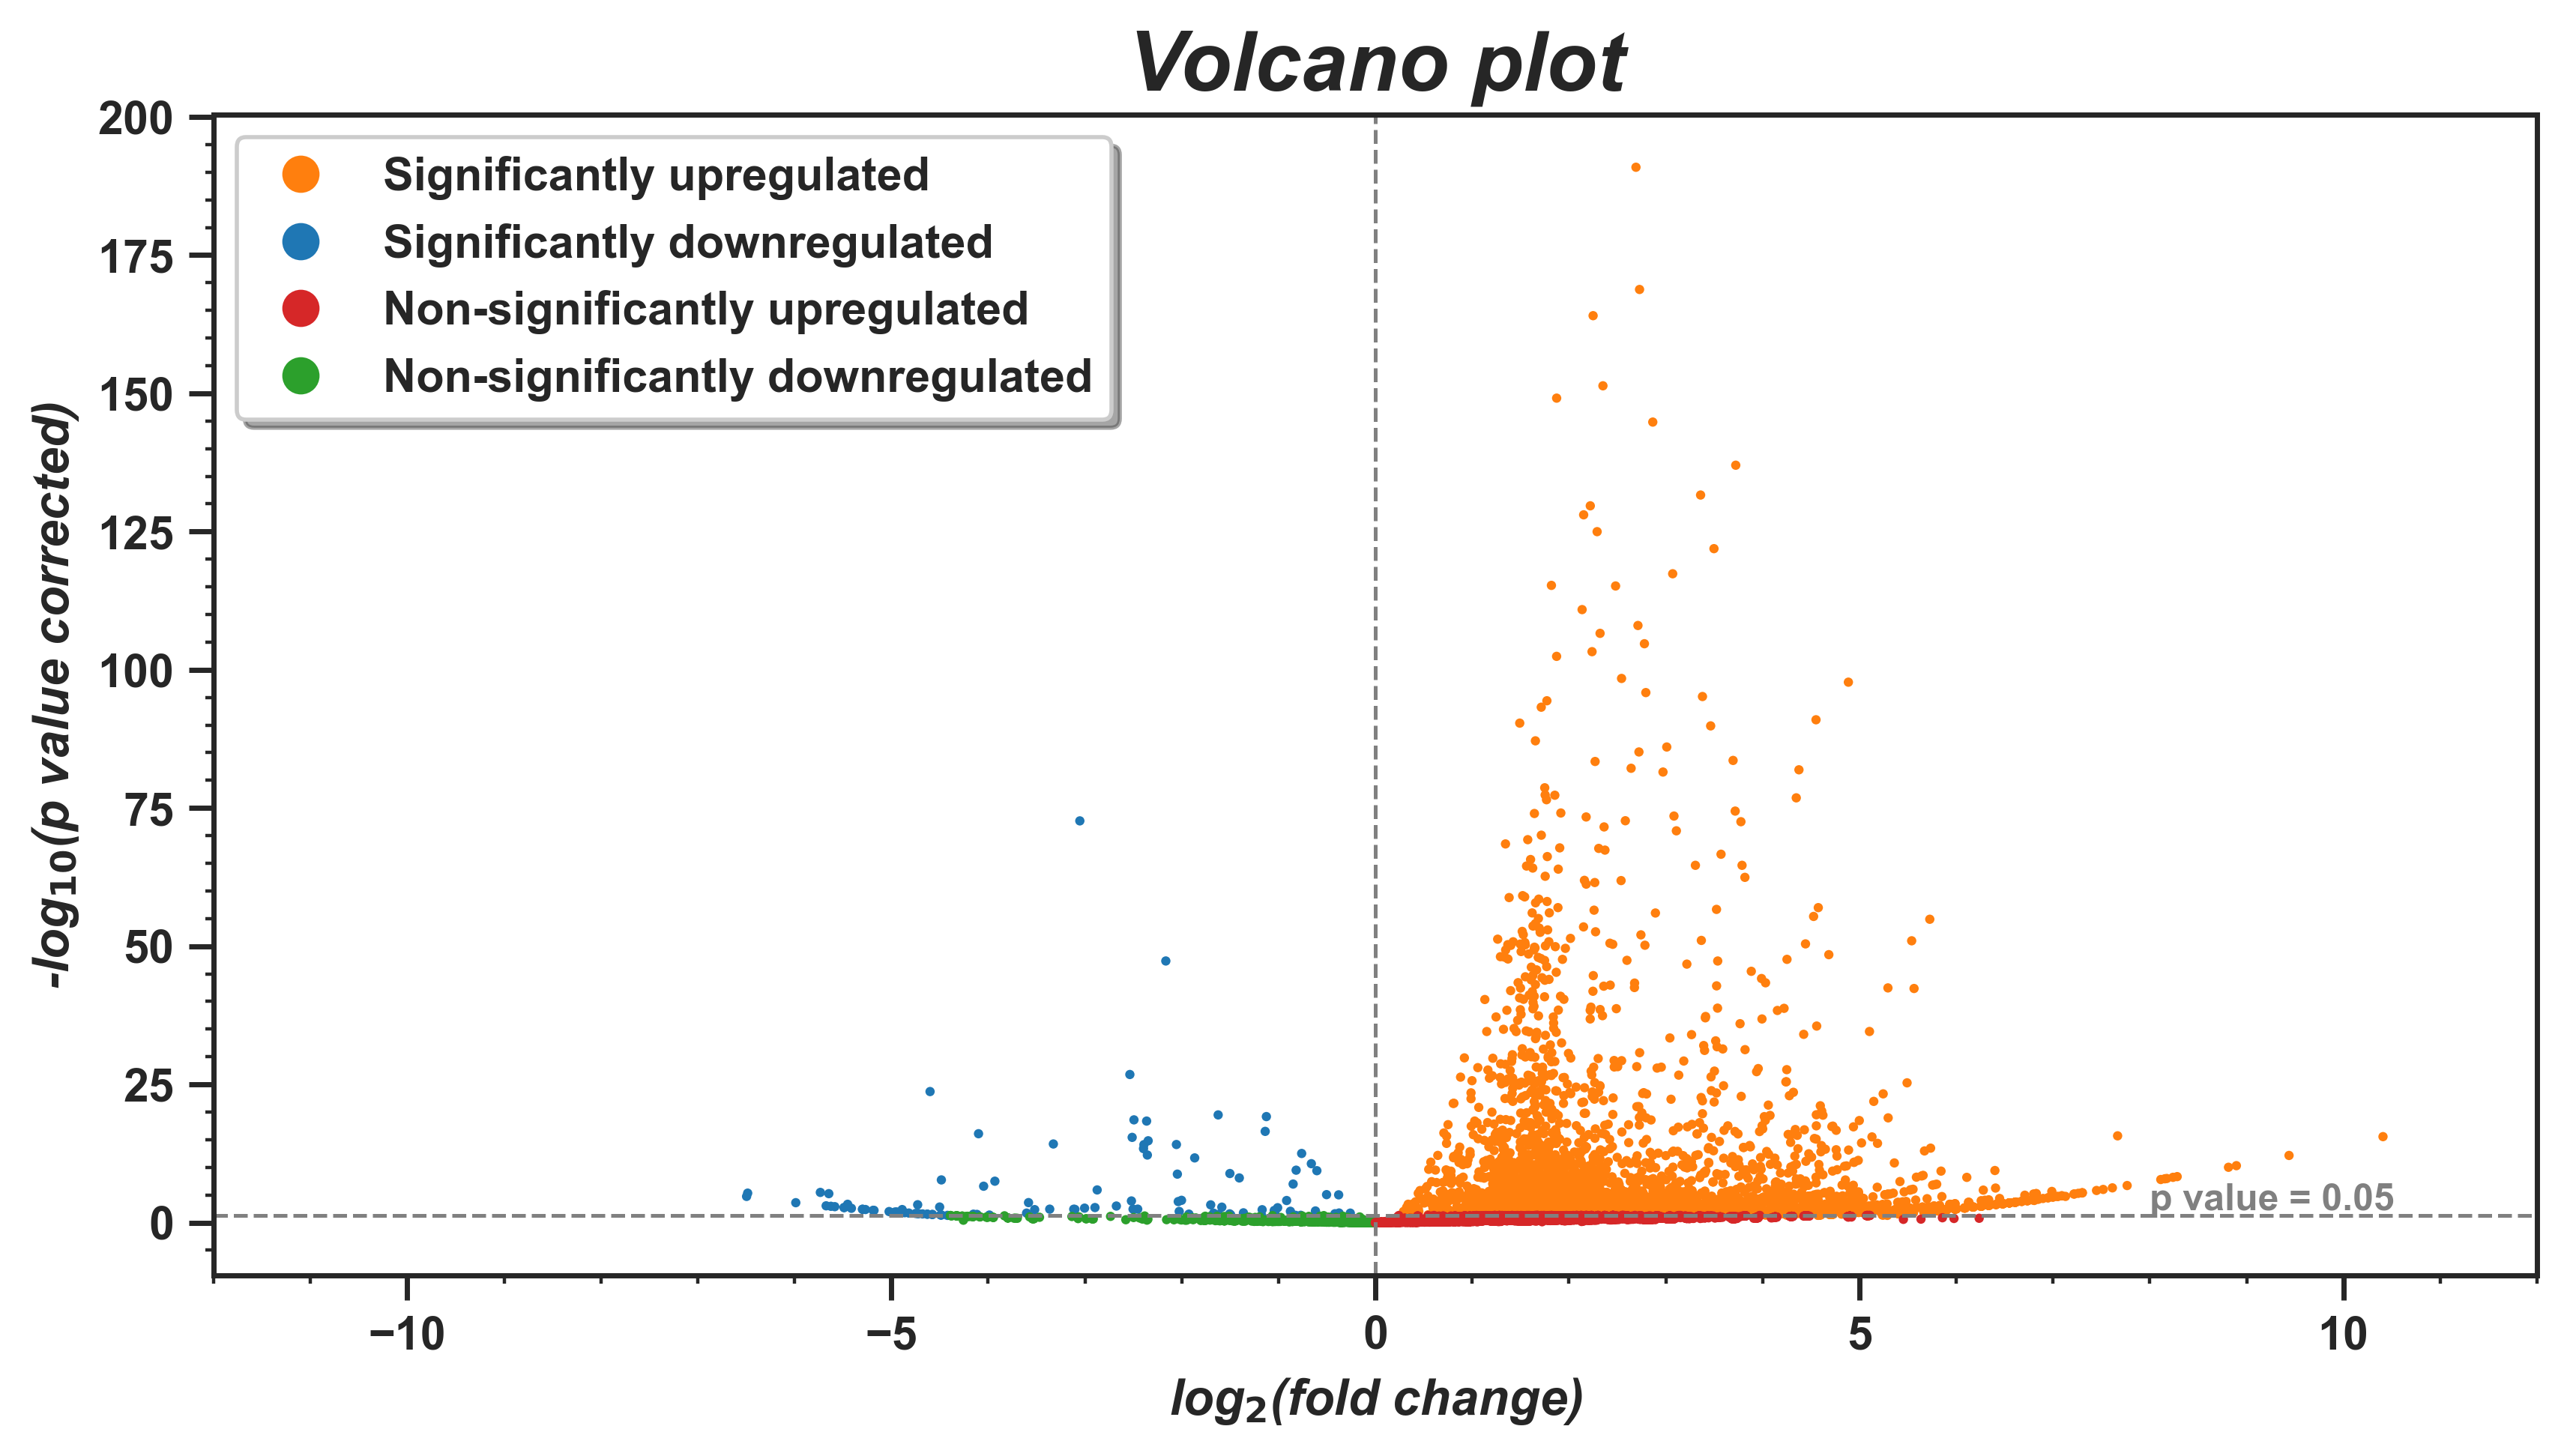

In [ ]:
sns.set_theme(style="ticks", font='sans-serif', rc={'figure.figsize': (10, 5.03)})
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 3
plt.rcParams['font.weight'] = 'bold'

volcano = sns.scatterplot(data=volcano_deseq, x='log2FoldChange', y='log_padj', hue='expression_change', palette=palette, s=5, linewidth=0)

plt.text(8, -np.log10(0.05) + 1, 'p value = 0.05', c='grey', fontfamily='sans-serif', size=9, weight='bold')
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--', linewidth=0.9)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.9)

xlim = int(np.ceil(volcano_deseq.log2FoldChange.abs().max())) + 1
plt.xlim(-xlim, xlim)
volcano.set_xticks(np.linspace(-xlim, xlim, xlim*2 + 1), minor=True)

y_prec = 5
ymin = int(y_prec * np.floor(volcano_deseq.log_padj.min() / y_prec - 1))
ymax = int(y_prec * np.floor(volcano_deseq.log_padj.max() / y_prec + 1))
volcano.set_yticks(np.linspace(ymin, ymax, int((ymax - ymin)/y_prec) + 1), minor=True)

volcano.tick_params(which='minor', length=2, width=0.8)
volcano.set_title('Volcano plot', weight='black', style='italic', fontsize=20)
volcano.set_xlabel('log$_2$(fold change)', weight='black', style='italic')
volcano.set_ylabel('-log$_{10}$(p value corrected)', weight='black', style='italic')

plt.legend(shadow=True, title=None, markerscale=4)
plt.savefig('../data_folder/processed_data/4.Expression_count/kallisto/dynamena_volcano.png', dpi=300)
plt.show()

## 6. Identify transcripts with significant changes in expression

### 6.1 Identify transcripts with significant changes in expression

In [7]:
deseq_results_ctrl_sig = deseq_results_ctrl.query('padj < 0.05')
kallisto_matrix_ctrl_sig = kallisto_matrix.loc[deseq_results_ctrl_sig.index]

In [11]:
deseq_results_ctrl_sig_file = '../data_folder/processed_data/4.Expression_count/DESeq2/result_ctrl_sig.txt'
kallisto_matrix_ctrl_sig_file = '../data_folder/processed_data/4.Expression_count/kallisto/count_martix_ctrl_sig.txt'

In [15]:
deseq_results_ctrl_sig.to_csv(deseq_results_ctrl_sig_file, sep='\t')
kallisto_matrix_ctrl_sig.to_csv(kallisto_matrix_ctrl_sig_file, sep='\t')

#### Draw clustermap

In [16]:
meta = pd.DataFrame({'Control (DMSO) 1': ('DMSO', 1),
                     'Control (DMSO) 2': ('DMSO', 2),
                     'Control (DMSO) 3': ('DMSO', 3),
                     'AZK treated 1': ('AZK', 1), 
                     'AZK treated 2': ('AZK', 2),
                     'AZK treated 3': ('AZK', 3),}, index=['Sample', 'Replicate']).T

In [17]:
col_colors = meta['Sample'].map({'AZK': '#7247D7', 'DMSO': '#8D6DD7'})
col_colors.name = 'Sample'
rep_colors = meta['Replicate'].map({1: '#0099CC', 2: '#666BFF', 3: '#66CCFF'})
rep_colors.name = 'Replicate'
col_colors = pd.concat([col_colors, rep_colors], axis=1)

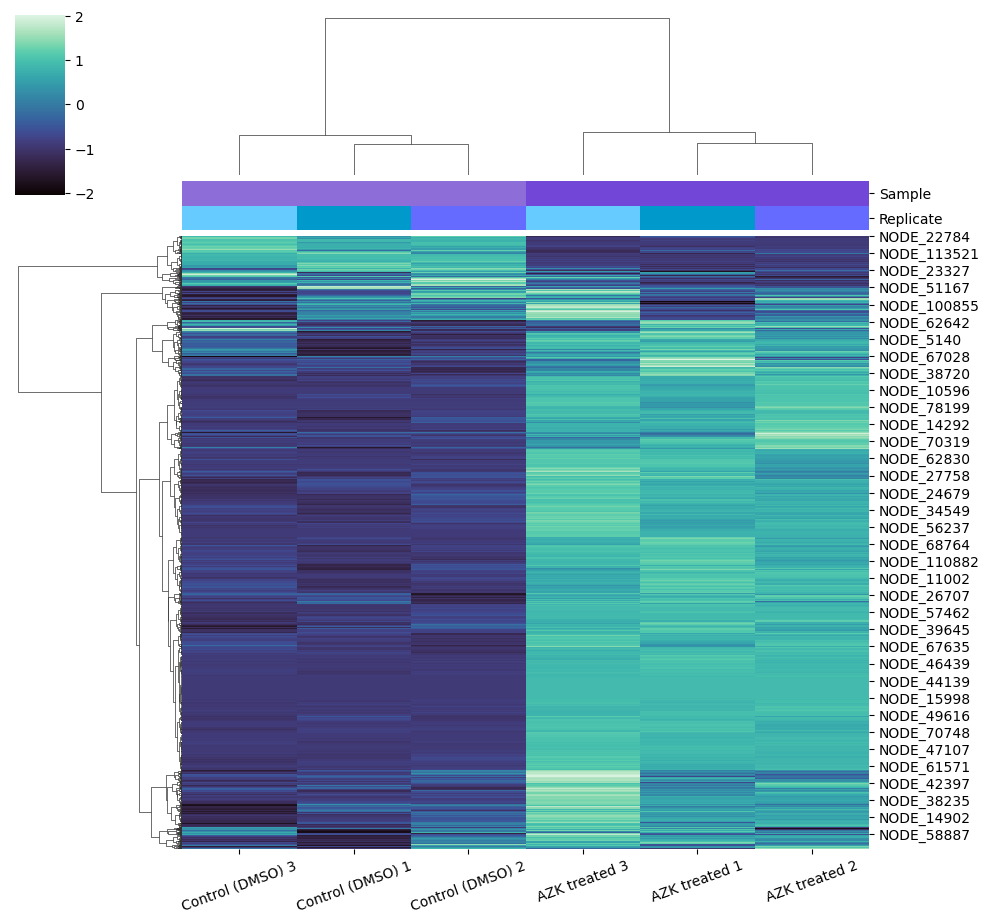

In [18]:
kallisto_ctrl_cluster_df = pd.read_csv(kallisto_matrix_ctrl_sig_file, sep='\t', index_col=0)
clustermap_cols = ('Control (DMSO) 1', 'Control (DMSO) 2','Control (DMSO) 3', 'AZK treated 1','AZK treated 2','AZK treated 3')
kallisto_ctrl_cluster_df = kallisto_ctrl_cluster_df.rename(columns=dict(zip(kallisto_ctrl_cluster_df.columns, clustermap_cols)))
kallisto_ctrl_cluster_df = kallisto_ctrl_cluster_df.set_index(kallisto_matrix_ctrl_sig.index.str.split('_', n=2).str[:2].str.join('_'))

kallisto_cluster = sns.clustermap(kallisto_ctrl_cluster_df, method='ward', cmap='mako', z_score=0, col_colors=col_colors)
plt.setp(kallisto_cluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=20)  # https://stackoverflow.com/a/34697479
plt.savefig('../data_folder/processed_data/4.Expression_count/kallisto/kallisto_matrix_ctrl_sig.png', dpi=300)
None

### 6.2 Drag sequencies from reference

#### `OpenFasta`

In [23]:
fasta_records = []
with OpenFasta('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta') as gene_extractor:
    for gene in gene_extractor:
        if gene.rec_id in deseq_results_ctrl_sig.index:
            fasta_records.append(gene)
        if len(fasta_records) == len(deseq_results_ctrl_sig.index):
            break

##### Check

In [24]:
records = SeqIO.parse('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta', 'fasta')  # https://biopython.org/wiki/SeqIO
fasta_records_seqio = []
for record in records:
    if record.id in deseq_results_ctrl_sig.index:
            fasta_records_seqio.append(record)
    if len(fasta_records_seqio) == len(deseq_results_ctrl_sig.index):
        break

In [25]:
fasta_check = []
for (fasta_seqio, fasta_openfasta) in zip(fasta_records_seqio, fasta_records):
    fasta_check.append(str(fasta_seqio.seq) == fasta_openfasta.rec_seq)

print(all(fasta_check))

True


### 6.3 Write sequencies to file

In [ ]:
%%bash
mkdir -p data_folder/processed_data/6.Identify_100/kegg

In [38]:
with open('../data_folder/processed_data/6.Identify_100/results_ctrl_sig_seqs.fasta', mode='w+') as results_ctrl_sig_seqs:
    for fasta in fasta_records:
        results_ctrl_sig_seqs.write(f'>{fasta.rec_id} {fasta.rec_desc}\n')
        results_ctrl_sig_seqs.write(f'{fasta.rec_seq}\n')
        results_ctrl_sig_seqs.write('\n')

### 6.4 Convert nucleotide sequencies to protein

In [ ]:
%%bash
TransDecoder.LongOrfs -t data_folder/processed_data/6.Identify_100/results_ctrl_sig_seqs.fasta

### 6.5 BLAST sequencies

BLAST:

*   `tblastx`
*   Cnidaria (taxid:6073)

kegg:

*   https://www.genome.jp/tools/kofamkoala/

In [27]:
def read_kegg_file(file):
    with open(file) as kegg_table:
        header = [[]]
        for char_header, char_sep in zip(kegg_table.readline().lstrip(), kegg_table.readline().lstrip()):
            if char_sep == '-':
                header[-1].append(char_header)
            elif char_sep == ' ':
                header[-1] = ''.join(header[-1]).strip()
                header.append([])
        header[-1] = ''.join(header[-1]).strip()
        
        results = []
        for line in kegg_table:
            results.append(line.lstrip('*').strip().split(None, len(header)-1))
        
        return pd.DataFrame(results, columns=header)#.set_index(header[0])

In [30]:
results_sig_kegg = read_kegg_file('../data_folder/processed_data/6.Identify_100/kegg/result_all_sig.txt')

In [31]:
results_sig_kegg.head(15)

,gene name,KO,thrshld,score,E-value,KO definition
0,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K04600,4237.17,4221.7,0,cadherin EGF LAG seven-pass G-type receptor 1
1,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K04601,4867.83,4105.9,0,cadherin EGF LAG seven-pass G-type receptor 2
2,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K04602,4927.60,2238.6,0,cadherin EGF LAG seven-pass G-type receptor 3
3,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K22659,1320.80,1377.6,0,calsyntenin 1
4,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K07600,1599.40,1127.1,0,desmocollin 1
5,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K16507,1769.90,1104.8,0,protocadherin-16/23
6,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K16669,1399.10,928.4,3.6e-279,protocadherin Fat 4
7,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K07598,1439.33,888.2,2.4e-267,desmoglein 3
8,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K22660,1472.47,676.9,1.7e-203,calsyntenin 2
9,NODE_11_length_23547_cov_202.534377_g1_i2.p1,K07596,1692.70,660.7,1.3e-198,desmoglein 1


In [32]:
results_sig_kegg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253290 entries, 0 to 253289
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   gene name      253290 non-null  object
 1   KO             253290 non-null  object
 2   thrshld        253290 non-null  object
 3   score          253290 non-null  object
 4   E-value        253290 non-null  object
 5   KO definition  253290 non-null  object
dtypes: object(6)
memory usage: 11.6+ MB


In [33]:
results_sig_kegg_group = pd.DataFrame(results_sig_kegg[['KO definition', 'gene name']].groupby('KO definition')['gene name'].apply(list)).reset_index()
results_sig_kegg_group['counts'] = results_sig_kegg_group['gene name'].apply(len)
results_sig_kegg_group = results_sig_kegg_group.sort_values(by='counts', ascending=False).drop(0)

In [34]:
results_sig_kegg_group.head(30)

,KO definition,gene name,counts
72,-,"[NODE_11_length_23547_cov_202.534377_g1_i2.p2,...",2335
16209,uncharacterized protein,"[NODE_26_length_17337_cov_350.856713_g5_i5.p1,...",872
10898,mitogen-activated protein kinase kinase [EC:2....,[NODE_2082_length_7423_cov_274.972358_g222_i2....,316
10919,mitogen-activated protein kinase kinase kinase...,[NODE_1358_length_8502_cov_282.498995_g323_i0....,304
10899,mitogen-activated protein kinase kinase kinase...,[NODE_2082_length_7423_cov_274.972358_g222_i2....,210
12730,prosaposin receptor,[NODE_3318_length_6327_cov_237.728835_g10_i823...,201
7032,cyclin-dependent kinase [EC:2.7.11.22],[NODE_2082_length_7423_cov_274.972358_g222_i2....,201
10908,mitogen-activated protein kinase kinase kinase...,[NODE_2082_length_7423_cov_274.972358_g222_i2....,199
11734,otogelin,[NODE_98_length_14895_cov_576.753771_g29_i0.p1...,198
10889,mitogen-activated protein kinase kinase 1 [EC:...,[NODE_2082_length_7423_cov_274.972358_g222_i2....,197


In [35]:
results_sig_kegg_group.to_csv('../data_folder/processed_data/6.Identify_100/kegg/result_sig_all_grouped.txt', sep='\t')

#### KOd group counts

In [36]:
results_kegg_KOd_counts = pd.DataFrame(results_sig_kegg['KO definition'].value_counts().drop('-')).reset_index()

In [37]:
results_kegg_KOd_counts.head(15)

,KO definition,count
0,uncharacterized protein,872
1,mitogen-activated protein kinase kinase [EC:2....,316
2,mitogen-activated protein kinase kinase kinase...,304
3,mitogen-activated protein kinase kinase kinase...,210
4,cyclin-dependent kinase [EC:2.7.11.22],201
5,prosaposin receptor,201
6,mitogen-activated protein kinase kinase kinase...,199
7,otogelin,198
8,mitogen-activated protein kinase kinase 1 [EC:...,197
9,mitogen-activated protein kinase kinase 3 [EC:...,195


In [38]:
results_kegg_KOd_counts.to_csv('../data_folder/processed_data/6.Identify_100/kegg/result_all_KOd_counts.txt', sep='\t')

#### Check for Delta/Notch

In [39]:
search_target = ['Notch', 'protein delta']

In [80]:
results_sig_kegg_group_dn = results_sig_kegg_group[results_sig_kegg_group['KO definition'].str.contains('|'.join(search_target))]

In [81]:
results_sig_kegg_group_dn

,KO definition,gene name,counts
3360,Notch 1,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,100
3361,Notch 2,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,97
3363,Notch 4,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,91
3362,Notch 3,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,89
12947,protein delta homolog 2,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,61
3364,Notch homolog 2 N-terminal-like protein,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,57
12946,protein delta homolog 1,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,54
7400,delta and Notch-like epidermal growth factor-r...,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,53
3365,Notch-regulated ankyrin repeat-containing protein,[NODE_1358_length_8502_cov_282.498995_g323_i0....,35
14093,signal-regulatory protein delta,[NODE_1674_length_8027_cov_301.122871_g400_i0....,19


In [95]:
results_sig_kegg_group_dn.counts.sum()

664

In [83]:
nodes_list = results_sig_kegg_group_dn['gene name'].explode()
kallisto_matrix.loc[list(set(map(lambda x: x.rsplit('.', 1)[0], nodes_list))), :]

,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
target_id,,,,,,
NODE_24642_length_2555_cov_109.672771_g6067_i0,1,1,2,6,6,6
NODE_5681_length_5195_cov_243.217974_g1192_i1,9,11,7,11,15,12
NODE_11869_length_3817_cov_543.115527_g2854_i0,17,17,16,30,26,31
NODE_18886_length_3008_cov_228.881282_g4610_i0,4,5,5,11,10,11
NODE_34354_length_1964_cov_699.799063_g2854_i6,60,61,59,95,105,104
...,...,...,...,...,...,...
NODE_49946_length_1252_cov_188.574028_g10802_i1,1,2,2,7,7,6
NODE_24015_length_2601_cov_310.121970_g5907_i0,5,6,4,9,11,12
NODE_50281_length_1238_cov_659.259414_g14284_i0,35,36,36,65,60,66


#### Check for collagens

In [84]:
search_target = ['collagen']

In [85]:
results_sig_kegg_group_cl = results_sig_kegg_group[results_sig_kegg_group['KO definition'].str.contains('|'.join(search_target))]

In [86]:
results_sig_kegg_group_cl

,KO definition,gene name,counts
6786,collagen type VII alpha,[NODE_48_length_16471_cov_226.539506_g13_i1.p1...,98
6797,collagen type XX alpha,[NODE_48_length_16471_cov_226.539506_g13_i1.p1...,76
6791,collagen type XIV alpha,[NODE_48_length_16471_cov_226.539506_g13_i1.p1...,75
6785,collagen type VI alpha,[NODE_48_length_16471_cov_226.539506_g13_i1.p1...,72
6775,collagen and calcium-binding EGF domain-contai...,[NODE_178_length_12997_cov_262.473985_g48_i1.p...,69
6789,collagen type XII alpha,[NODE_48_length_16471_cov_226.539506_g13_i1.p1...,67
6779,collagen type II alpha,[NODE_1148_length_8900_cov_481.482443_g268_i0....,66
6803,collagen type XXVIII alpha,[NODE_48_length_16471_cov_226.539506_g13_i1.p1...,65
6799,collagen type XXII alpha,[NODE_48_length_16471_cov_226.539506_g13_i1.p1...,61
6798,collagen type XXI alpha,[NODE_48_length_16471_cov_226.539506_g13_i1.p1...,60


#### Примечания

##### 1. [Список](https://ncbi.github.io/blast-cloud/blastdb/available-blastdbs.html) баз данных. `# https://stackoverflow.com/a/29496260`

##### 2. Запросы через сайт NCBI обрабатываются в приоритете:

[Usage Guidelines](https://blast.ncbi.nlm.nih.gov/doc/blast-help/developerinfo.html#usage-guidelines)

The NCBI BLAST servers are a shared resource. We give priority to interactive users. In order to ensure availability of the service to the entire community, we may limit searches for some high volume users. Interactive users of the NCBI webpages through a web browser should not encounter problems. We will move searches of users who submit more than 100 searches in a 24 hour period to a slower queue, or, in extreme cases, will block the requests. To avoid problems, API users should comply with the following guidelines:

*   Do not contact the server more often than once every 10 seconds.

*   Do not poll for any single RID more often than once a minute.

*   Use the URL parameter email and tool, so that the NCBI can contact you if there is a problem.

*   Run scripts weekends or between 9 pm and 5 am Eastern time on weekdays if more than 50 searches will be submitted.

BLAST often runs more efficiently if multiple queries are sent as one search rather than if each query is sent as an individual search. This is especially true for blastn, megablast, and tblastn. If your queries are short (less than a few hundred bases) we suggest you merge them into one search of up to 1,000 bases

The NCBI servers are a shared resource and not intended for projects that involve a large number of BLAST searches. We provide the Stand-alone BLAST+ binaries, Docker Image and Elastic BLAST for these purposes.

## 7. Identify 100 transcripts with most remarkable upregulation and 100 transcripts with most remarkable downregulation in expression

### 7.1 Identify all transcripts with significant upregulation or downregulation in expression

In [51]:
deseq_results_lfc_neg = deseq_results_ctrl.query('padj < 0.05 and log2FoldChange < 0').sort_values(by='log2FoldChange')
deseq_results_lfc_pos = deseq_results_ctrl.query('padj < 0.05 and log2FoldChange > 0').sort_values(by='log2FoldChange', ascending=False)

In [52]:
deseq_results_lfc_neg.head(100)

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_41200_length_1625_cov_455.115044_g10_i9542,NODE_41200_length_1625_cov_455.115044_g10_i9542,12.71,-6.49,1.36,-4.79,0.00,0.00
NODE_75630_length_487_cov_299.308559_g31728_i0,NODE_75630_length_487_cov_299.308559_g31728_i0,24.84,-6.48,1.28,-5.08,0.00,0.00
NODE_118564_length_177_cov_4.052239_g74583_i0,NODE_118564_length_177_cov_4.052239_g74583_i0,8.94,-5.99,1.43,-4.17,0.00,0.00
NODE_65404_length_717_cov_420.952522_g22751_i0,NODE_65404_length_717_cov_420.952522_g22751_i0,27.74,-5.73,1.11,-5.14,0.00,0.00
NODE_72911_length_539_cov_12.485887_g29128_i0,NODE_72911_length_539_cov_12.485887_g29128_i0,7.19,-5.67,1.48,-3.83,0.00,0.00
...,...,...,...,...,...,...,...
NODE_54360_length_1076_cov_686.294288_g16046_i0,NODE_54360_length_1076_cov_686.294288_g16046_i0,173.40,-0.92,0.21,-4.40,0.00,0.00
NODE_33124_length_2030_cov_1010.917967_g8431_i0,NODE_33124_length_2030_cov_1010.917967_g8431_i0,190.22,-0.88,0.28,-3.12,0.00,0.01
NODE_24058_length_2598_cov_603.844618_g5029_i3,NODE_24058_length_2598_cov_603.844618_g5029_i3,385.64,-0.85,0.15,-5.79,0.00,0.00
NODE_59419_length_903_cov_451.786047_g16029_i3,NODE_59419_length_903_cov_451.786047_g16029_i3,56.89,-0.84,0.34,-2.44,0.01,0.05


In [53]:
deseq_results_lfc_pos.head(100)

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_30129_length_2202_cov_506.623437_g10_i7576,NODE_30129_length_2202_cov_506.623437_g10_i7576,81.58,10.41,1.21,8.59,0.00,0.00
NODE_25561_length_2490_cov_379.813241_g2076_i4,NODE_25561_length_2490_cov_379.813241_g2076_i4,41.62,9.44,1.24,7.61,0.00,0.00
NODE_14439_length_3485_cov_425.093260_g10_i4025,NODE_14439_length_3485_cov_425.093260_g10_i4025,28.54,8.89,1.27,7.02,0.00,0.00
NODE_82667_length_385_cov_348.511696_g38695_i0,NODE_82667_length_385_cov_348.511696_g38695_i0,26.97,8.81,1.27,6.92,0.00,0.00
NODE_35799_length_1887_cov_172.728308_g10_i8617,NODE_35799_length_1887_cov_172.728308_g10_i8617,18.69,8.28,1.31,6.32,0.00,0.00
...,...,...,...,...,...,...,...
NODE_14953_length_3425_cov_220.455648_g3615_i0,NODE_14953_length_3425_cov_220.455648_g3615_i0,4.60,6.26,1.65,3.79,0.00,0.00
NODE_33141_length_2030_cov_142.261701_g5824_i2,NODE_33141_length_2030_cov_142.261701_g5824_i2,4.60,6.26,1.65,3.79,0.00,0.00
NODE_53087_length_1124_cov_617.274746_g15437_i0,NODE_53087_length_1124_cov_617.274746_g15437_i0,4.60,6.26,1.66,3.77,0.00,0.00
NODE_64798_length_735_cov_75.622832_g22288_i0,NODE_64798_length_735_cov_75.622832_g22288_i0,9.06,6.26,1.43,4.38,0.00,0.00


In [54]:
deseq_lfc_pos_results_100 = deseq_results_lfc_pos.head(100)
deseq_lfc_neg_results_100 = deseq_results_lfc_neg.head(100)
kallisto_matrix_pos_100 = kallisto_matrix.loc[deseq_lfc_pos_results_100.index]
kallisto_matrix_neg_100 = kallisto_matrix.loc[deseq_lfc_neg_results_100.index]

### 7.2 Drag sequencies from reference

In [55]:
fasta_records_all_pos, fasta_records_all_neg = [], []
len_pos, len_neg = len(deseq_results_lfc_pos.index), len(deseq_results_lfc_neg.index)
with OpenFasta('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta') as gene_extractor:
    for gene in gene_extractor:
        len_pos, len_neg = len(fasta_records_all_pos), len(fasta_records_all_neg)
        if gene.rec_id in deseq_results_lfc_pos.index:
            fasta_records_all_pos.append(gene)
        elif gene.rec_id in deseq_results_lfc_neg.index:
            fasta_records_all_neg.append(gene)

In [56]:
print(len(fasta_records_all_pos))
print(len(fasta_records_all_neg))

5085
111


In [57]:
fasta_records_100_pos, fasta_records_100_neg = [], []
len_100_pos, len_100_neg = len(deseq_lfc_pos_results_100.index), len(deseq_lfc_neg_results_100.index)
with OpenFasta('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta') as gene_extractor:
    for gene in gene_extractor:
        len_pos, len_neg = len(fasta_records_100_pos), len(fasta_records_100_neg)
        if len_pos < len_100_pos and gene.rec_id in deseq_lfc_pos_results_100.index:
            fasta_records_100_pos.append(gene)
        elif len_neg < len_100_pos and gene.rec_id in deseq_lfc_neg_results_100.index:
            fasta_records_100_neg.append(gene)
        elif len_pos + len_neg == 200:
            break

In [58]:
print(len(fasta_records_100_pos))
print(len(fasta_records_100_neg))

100
100


#### Draw clustermaps

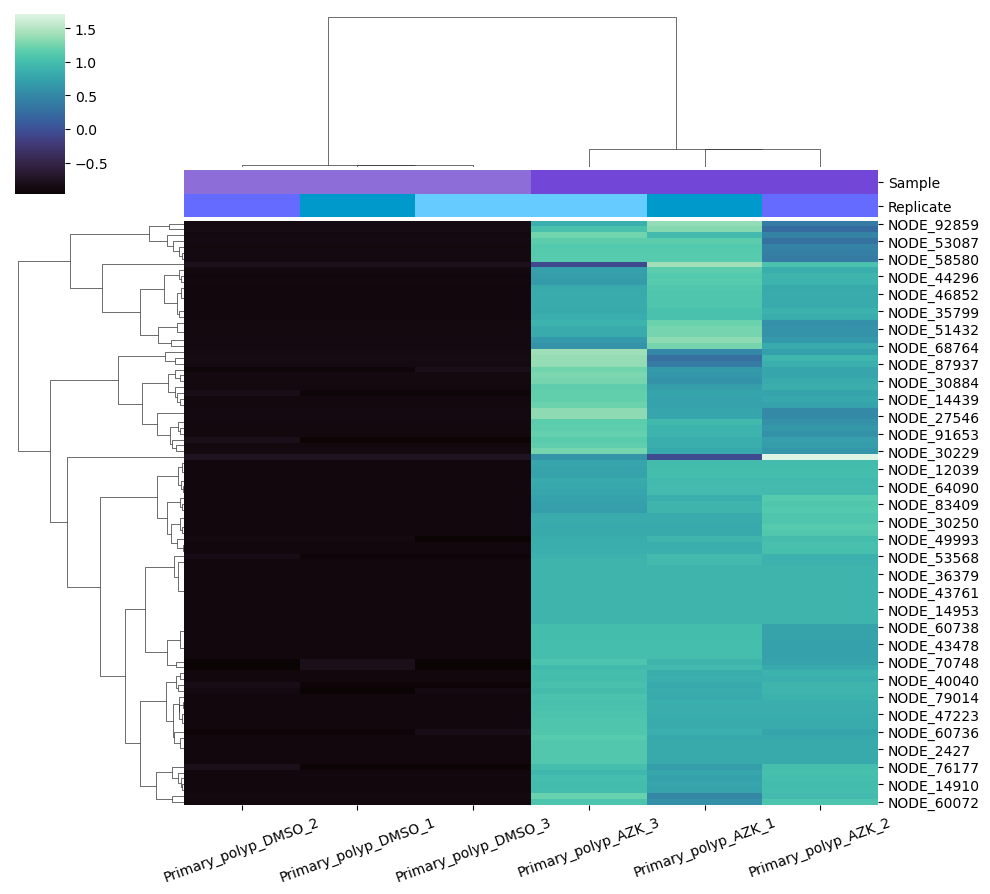

In [32]:
kallisto_cluster_pos_100_df = kallisto_matrix_pos_100.set_index(kallisto_matrix_pos_100.index.str.split('_', n=2).str[:2].str.join('_'))

kallisto_cluster_pos_100 = sns.clustermap(kallisto_cluster_pos_100_df, method='ward', cmap='mako', z_score=0, col_colors=col_colors)
plt.setp(kallisto_cluster_pos_100.ax_heatmap.xaxis.get_majorticklabels(), rotation=20)  # https://stackoverflow.com/a/34697479
plt.savefig('../data_folder/processed_data/4.Expression_count/kallisto/kallisto_matrix_pos_100.png', dpi=300)
None

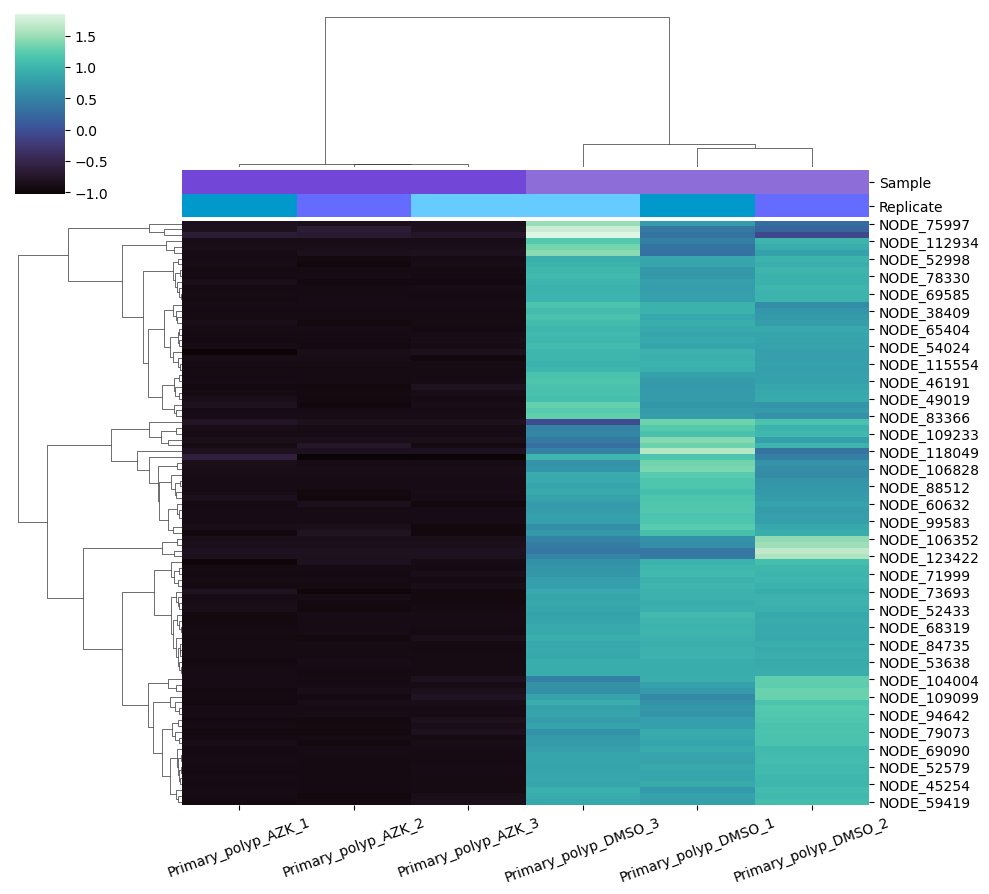

In [33]:
kallisto_cluster_neg_100_df = kallisto_matrix_neg_100.set_index(kallisto_matrix_neg_100.index.str.split('_', n=2).str[:2].str.join('_'))

kallisto_cluster_neg_100 = sns.clustermap(kallisto_cluster_neg_100_df, method='ward', cmap='mako', z_score=0, col_colors=col_colors)
plt.setp(kallisto_cluster_neg_100.ax_heatmap.xaxis.get_majorticklabels(), rotation=20)  # https://stackoverflow.com/a/34697479
plt.savefig('../data_folder/processed_data/4.Expression_count/kallisto/kallisto_matrix_neg_100.png', dpi=300)
None

### 7.3 Write sequencies to file

In [ ]:
%%bash
mkdir -p data_folder/processed_data/7.Identify_100and100/pos
mkdir -p data_folder/processed_data/7.Identify_100and100/neg

In [240]:
with open('../data_folder/processed_data/7.Identify_100and100/pos/fasta_all_pos.fasta', mode='w+') as fasta_all_pos:
    for fasta in fasta_records_all_pos:
        fasta_all_pos.write(f'>{fasta.rec_id} {fasta.rec_desc}\n')
        fasta_all_pos.write(f'{fasta.rec_seq}\n')
        fasta_all_pos.write('\n')

In [242]:
with open('../data_folder/processed_data/7.Identify_100and100/neg/fasta_all_neg.fasta', mode='w+') as fasta_all_neg:
    for fasta in fasta_records_all_neg:
        fasta_all_neg.write(f'>{fasta.rec_id} {fasta.rec_desc}\n')
        fasta_all_neg.write(f'{fasta.rec_seq}\n')
        fasta_all_neg.write('\n')

In [34]:
with open('../data_folder/processed_data/7.Identify_100and100/pos/fasta_100_pos.fasta', mode='w+') as fasta_100_pos:
    for fasta in fasta_records_100_pos:
        fasta_100_pos.write(f'>{fasta.rec_id} {fasta.rec_desc}\n')
        fasta_100_pos.write(f'{fasta.rec_seq}\n')
        fasta_100_pos.write('\n')

In [35]:
with open('../data_folder/processed_data/7.Identify_100and100/neg/fasta_100_neg.fasta', mode='w+') as fasta_100_neg:
    for fasta in fasta_records_100_neg:
        fasta_100_neg.write(f'>{fasta.rec_id} {fasta.rec_desc}\n')
        fasta_100_neg.write(f'{fasta.rec_seq}\n')
        fasta_100_neg.write('\n')

### 7.4 Convert nucleotide sequencies to protein

In [ ]:
%%bash
TransDecoder.LongOrfs -t data_folder/processed_data//7.Identify_100and100/pos/fasta_100_pos.fasta
# mv -f fasta_100_pos.fasta.transdecoder_dir data_folder/processed_data/7.Identify_100and100/pos

TransDecoder.LongOrfs -t data_folder/processed_data//7.Identify_100and100/neg/fasta_100_neg.fasta
# mv fasta_100_neg.fasta.transdecoder_dir data_folder/processed_data/7.Identify_100and100/neg

In [59]:
fasta_100_pos_path = '../data_folder/processed_data/7.Identify_100and100/pos/fasta_100_pos.fasta.transdecoder_dir/longest_orfs.pep'
with OpenFasta(fasta_100_pos_path) as fasta_p:
    print(fasta_p.read_record())

ID: NODE_1853_length_7727_cov_246.504425_g229_i1.p1
Description: type:complete gc:universal NODE_1853_length_7727_cov_246.504425_g229_i1:95-5923(+)
Sequence: MKKCCGCKLTYPILIVTILIHAVLGELPKFSELPADGTTAAYRGSLTLKCSASGTPPPKIVNWLLNDKPVNFNTGNHFLRPSGELHITSAQKSDSGFYQCVAWNTDGEAVSAKRRVDIAYRPFQPSSPRVTDIQPFSLTVSWDAPSDGGSALLGFVLYMKNATMGQYVVLAKLNASETTYTIKMLHAGSLYRFQVAAENKFGQGERSVESHWIETTTLAPSGAPKDFRSFDAGTDFVKLAWKAPALANLNGKLLGYNIGYRVTGFEGEGLFTIIDLRSTRTEYEMTGLPLFTKYEVKVAAYNKAGRGPWSNVNYVATLQGIPSSGPTDVTVSVKNSTTVLVSFTSPPQQLRNGQLTSIIARYWPPELPQNQLQYRTKYDTSSIYKQSFYLPTLAADREYVLAVAVGTIGGWSPGSLTVQFRTKQGRPEQVQDLKVSNTYADAFTVSWKKPIKTGGTITAYVIKYRVFTSQTWRELKEHGKALDAVIPNLLPKTKYEVEVAAVTSAGLGPFTRRSAITAERPEPPKAPSNLKAYAVWGSSITLGWTPGDSGRAVILYYKIDYNNDTDYRLYPERAKWHMIPNLTKILKNPANITGLKPSSIYRFRMTAVNRVGPSLISNISDDITTGEGIPSGAPTDIIITAPIQKGLLIKWNPPTRESWNSGSVKYQFLIKPKGQDLKIKVPYMSHPDAQATSYTARGLQMYTEYNVTIRLYNDKGFGPWSKPAFLRTSEDYPSGAPTIQSSIVDSSSTVRLTWGPVPEDQRNGVILGYKVFYQISGVENTELFKDYPGNTTFSGVIDGLNGYTDYEFRLLAYTKVGGKLKSSPVTKKTKEGVPDKPTNVKF

### 7.5 BLAST results

In [60]:
results_100_pos_kegg = read_kegg_file('../data_folder/processed_data/7.Identify_100and100/pos/result_all_pos.txt')
results_100_neg_kegg = read_kegg_file('../data_folder/processed_data/7.Identify_100and100/neg/result_all_neg.txt')

In [61]:
results_100_pos_kegg.head(30)

,gene name,KO,thrshld,score,E-value,KO definition
0,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K16353,628.50,1013.9,0,protein sidekick
1,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K06756,1403.47,297.0,2e-90,neuronal cell adhesion molecule
2,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K06550,1443.87,295.2,7.4e-90,L1 cell adhesion molecule
3,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K06767,2276.60,281.5,8.9e-86,Down syndrome cell adhesion molecule
4,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K06778,3308.33,263.7,2.5e-80,receptor-type tyrosine-protein phosphatase S [...
5,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K06768,2533.07,257.1,1.9e-78,Down syndrome cell adhesion molecule-like prot...
6,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K05113,1622.77,228.0,1.6e-69,Eph receptor B4 [EC:2.7.10.1]
7,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K16910,928.03,227.2,1.7e-69,receptor-type tyrosine-protein phosphatase Q [...
8,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K06777,2938.53,219.6,5.5e-67,receptor-type tyrosine-protein phosphatase del...
9,NODE_1853_length_7727_cov_246.504425_g229_i1.p1,K05695,3058.27,218.5,1.3e-66,receptor-type tyrosine-protein phosphatase F [...


In [62]:
results_100_pos_kegg_group = pd.DataFrame(results_100_pos_kegg[['KO definition', 'gene name']].groupby('KO definition')['gene name'].apply(list)).reset_index()
results_100_pos_kegg_group['counts'] = results_100_pos_kegg_group['gene name'].apply(len)
results_100_pos_kegg_group = results_100_pos_kegg_group.sort_values(by='counts', ascending=False).drop(0)

In [63]:
results_100_pos_kegg_group.head(15)

,KO definition,gene name,counts
2,-,[NODE_2427_length_7033_cov_202.070959_g582_i0....,45
2594,uncharacterized protein,[NODE_1853_length_7727_cov_246.504425_g229_i1....,20
1738,neurofascin,[NODE_1853_length_7727_cov_246.504425_g229_i1....,6
266,FAD-dependent urate hydroxylase [EC:1.14.13.113],[NODE_25437_length_2499_cov_57.353827_g6287_i0...,6
1591,meprin A [EC:3.4.24.18],[NODE_14953_length_3425_cov_220.455648_g3615_i...,6
1650,mitogen-activated protein kinase kinase kinase...,[NODE_14439_length_3485_cov_425.093260_g10_i40...,5
1592,meprin B [EC:3.4.24.63],[NODE_14953_length_3425_cov_220.455648_g3615_i...,5
2071,putative membrane protein,[NODE_14439_length_3485_cov_425.093260_g10_i40...,5
2208,serine proteinase stubble [EC:3.4.21.-],[NODE_44296_length_1489_cov_322.641079_g12038_...,5
1356,inactive serine protease PAMR1,[NODE_30884_length_2159_cov_233.149811_g5470_i...,4


In [64]:
results_100_neg_kegg.head(30)

,gene name,KO,thrshld,score,E-value,KO definition
0,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K13884,217.63,80.9,4.1e-25,macrophage receptor with collagenous structure
1,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K16629,750.00,78.3,1.1e-24,collagen type XXI alpha
2,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K16630,575.27,74.7,1.3e-23,collagen type XXII alpha
3,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K06237,519.27,74.5,1.2e-23,collagen type IV alpha
4,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K19479,709.00,72.6,8.6e-23,collagen type X alpha
5,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K10062,408.57,70.3,4.6e-22,collectin sub-family member 12
6,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K08131,447.50,69.8,4.6e-22,collagen type IX alpha
7,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K19719,1687.27,68.4,6.2e-22,collagen type II alpha
8,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K19721,1082.43,65.9,5e-21,"collagen type V/XI/XXIV/XXVII, alpha"
9,NODE_24058_length_2598_cov_603.844618_g5029_i3.p1,K24214,427.57,65.0,2.7e-20,otolin-1


In [65]:
results_100_neg_kegg_group = pd.DataFrame(results_100_neg_kegg[['KO definition', 'gene name']].groupby('KO definition')['gene name'].apply(list)).reset_index()
results_100_neg_kegg_group['counts'] = results_100_neg_kegg_group['gene name'].apply(len)
results_100_neg_kegg_group = results_100_neg_kegg_group.sort_values(by='counts', ascending=False).drop(0)

In [66]:
results_100_neg_kegg_group.head(15)

,KO definition,gene name,counts
1,-,[NODE_30565_length_2177_cov_924.315370_g3250_i...,31
1105,pulmonary surfactant-associated protein D,[NODE_24058_length_2598_cov_603.844618_g5029_i...,9
531,collectin sub-family member 11,[NODE_24058_length_2598_cov_603.844618_g5029_i...,6
508,collagen type IV alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,6
515,collagen type XII alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,6
517,collagen type XIV alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,6
530,collectin sub-family member 10,[NODE_24058_length_2598_cov_603.844618_g5029_i...,6
506,collagen type II alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,6
326,agrin,[NODE_47558_length_1350_cov_507.627391_g13172_...,6
511,collagen type VI alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,6


#### KOd group counts

In [67]:
results_100_pos_kegg_KOd_counts = pd.DataFrame(results_100_pos_kegg['KO definition'].value_counts().drop('-')).reset_index()

In [68]:
results_100_pos_kegg_KOd_counts.head(15)

,KO definition,count
0,uncharacterized protein,20
1,neurofascin,6
2,FAD-dependent urate hydroxylase [EC:1.14.13.113],6
3,meprin A [EC:3.4.24.18],6
4,mitogen-activated protein kinase kinase kinase...,5
5,serine proteinase stubble [EC:3.4.21.-],5
6,meprin B [EC:3.4.24.63],5
7,putative membrane protein,5
8,platelet glycoprotein Ib alpha chain,4
9,hyaluronan binding protein 2 [EC:3.4.21.-],4


In [69]:
results_100_neg_kegg_KOd_counts = pd.DataFrame(results_100_neg_kegg['KO definition'].value_counts().drop('-')).reset_index()

In [70]:
results_100_neg_kegg_KOd_counts.head(15)

,KO definition,count
0,pulmonary surfactant-associated protein D,9
1,otolin-1,6
2,collagen type XII alpha,6
3,collectin sub-family member 11,6
4,collagen type VI alpha,6
5,collagen type VII alpha,6
6,collagen type XIV alpha,6
7,agrin,6
8,collectin sub-family member 10,6
9,collagen type IV alpha,6


#### Check for Delta/Notch

In [71]:
search_target = ['Notch', 'protein delta']

In [72]:
results_100_pos_kegg_group[results_100_pos_kegg_group['KO definition'].str.contains('|'.join(search_target))]

,KO definition,gene name,counts
2020,protein delta homolog 2,[NODE_30884_length_2159_cov_233.149811_g5470_i...,1
2019,protein delta homolog 1,[NODE_30884_length_2159_cov_233.149811_g5470_i...,1
391,Notch homolog 2 N-terminal-like protein,[NODE_30884_length_2159_cov_233.149811_g5470_i...,1
390,Notch 4,[NODE_30884_length_2159_cov_233.149811_g5470_i...,1
389,Notch 3,[NODE_30884_length_2159_cov_233.149811_g5470_i...,1
388,Notch 2,[NODE_30884_length_2159_cov_233.149811_g5470_i...,1
387,Notch 1,[NODE_30884_length_2159_cov_233.149811_g5470_i...,1
1059,delta and Notch-like epidermal growth factor-r...,[NODE_30884_length_2159_cov_233.149811_g5470_i...,1


In [73]:
pos_nodes_list = results_100_pos_kegg_group[results_100_pos_kegg_group['KO definition'].str.contains('|'.join(search_target))]['gene name'].explode()
kallisto_matrix.loc[list(set(map(lambda x: x.rsplit('.', 1)[0], pos_nodes_list))), :]

,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
target_id,,,,,,
NODE_30884_length_2159_cov_233.149811_g5470_i5,0,0,0,7,8,10


In [74]:
results_100_neg_kegg_group[results_100_neg_kegg_group['KO definition'].str.contains('|'.join(search_target))]

,KO definition,gene name,counts
1084,protein delta homolog 2,[NODE_24058_length_2598_cov_603.844618_g5029_i...,4
227,Notch homolog 2 N-terminal-like protein,[NODE_47558_length_1350_cov_507.627391_g13172_...,3
226,Notch 4,[NODE_47558_length_1350_cov_507.627391_g13172_...,3
225,Notch 3,[NODE_47558_length_1350_cov_507.627391_g13172_...,3
224,Notch 2,[NODE_47558_length_1350_cov_507.627391_g13172_...,3
223,Notch 1,[NODE_47558_length_1350_cov_507.627391_g13172_...,3
1083,protein delta homolog 1,[NODE_47558_length_1350_cov_507.627391_g13172_...,3
586,delta and Notch-like epidermal growth factor-r...,[NODE_47558_length_1350_cov_507.627391_g13172_...,3


In [75]:
neg_nodes_list = results_100_neg_kegg_group[results_100_neg_kegg_group['KO definition'].str.contains('|'.join(search_target))]['gene name'].explode()
kallisto_matrix.loc[list(set(map(lambda x: x.rsplit('.', 1)[0], neg_nodes_list))), :]

,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
target_id,,,,,,
NODE_51610_length_1185_cov_1041.008757_g14806_i0,12,13,15,0,0,1
NODE_79073_length_433_cov_174.048718_g35116_i0,15,17,13,0,0,1
NODE_47558_length_1350_cov_507.627391_g13172_i0,239,263,264,19,22,21
NODE_24058_length_2598_cov_603.844618_g5029_i3,718,834,733,178,173,188


## 8. Reveal changes in expression for set of specific canonical Wnt signaling pathway effectors.

In [76]:
with OpenFasta(r'../data_folder/raw_data/reads/Wnt/Wnt Fzd new transcr dynamena.txt') as fasta:
    for record in fasta:
        if record.rec_id in deseq_results_lfc_pos.index:
            print(record.rec_id)
        elif record.rec_id in deseq_results_lfc_neg.index:
            print(record.rec_id)

NODE_44651_length_1474_cov_59.382949_g12152_i0
NODE_27295_length_2377_cov_203.286632_g4657_i3
NODE_36166_length_1868_cov_546.405479_g9360_i0
NODE_30948_length_2155_cov_215.603693_g7827_i0
NODE_16900_length_3208_cov_219.899842_g4117_i0
NODE_36761_length_1838_cov_171.765460_g9539_i0
NODE_34088_length_1978_cov_180.238243_g7611_i1
NODE_9957_length_4131_cov_216.401419_g2360_i0


In [77]:
wnt_deseq, wnt_name = [], []
with OpenFasta(r'../data_folder/raw_data/reads/Wnt/Wnt Fzd new transcr dynamena.txt') as fasta:
    for record in fasta:
        if record.rec_id in deseq_results_lfc_pos.index:
            wnt_deseq.append(deseq_results_ctrl.loc[record.rec_id])
            wnt_name.append(record.rec_desc)
        elif record.rec_id in deseq_results_lfc_neg.index:
            wnt_deseq.append(deseq_results_ctrl.loc[record.rec_id])
            wnt_name.append(record.rec_desc)
wnt_deseq_df = pd.DataFrame(wnt_deseq)
wnt_deseq_df['wnt_name'] = wnt_name

In [78]:
wnt_deseq_df

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,wnt_name
NODE_44651_length_1474_cov_59.382949_g12152_i0,NODE_44651_length_1474_cov_59.382949_g12152_i0,5.41,3.15,1.18,2.68,0.01,0.03,Wnt1
NODE_27295_length_2377_cov_203.286632_g4657_i3,NODE_27295_length_2377_cov_203.286632_g4657_i3,5.28,3.49,1.26,2.76,0.01,0.02,Wnt3
NODE_36166_length_1868_cov_546.405479_g9360_i0,NODE_36166_length_1868_cov_546.405479_g9360_i0,44.27,2.12,0.39,5.47,0.00,0.00,Wnt5
NODE_30948_length_2155_cov_215.603693_g7827_i0,NODE_30948_length_2155_cov_215.603693_g7827_i0,25.47,1.85,0.50,3.68,0.00,0.00,Wnt6
NODE_16900_length_3208_cov_219.899842_g4117_i0,NODE_16900_length_3208_cov_219.899842_g4117_i0,15.97,2.66,0.66,4.02,0.00,0.00,Wnt7
NODE_36761_length_1838_cov_171.765460_g9539_i0,NODE_36761_length_1838_cov_171.765460_g9539_i0,58.72,1.38,0.33,4.19,0.00,0.00,Wnt11a
NODE_34088_length_1978_cov_180.238243_g7611_i1,NODE_34088_length_1978_cov_180.238243_g7611_i1,10.16,4.48,1.03,4.34,0.00,0.00,Wnt11b
NODE_9957_length_4131_cov_216.401419_g2360_i0,NODE_9957_length_4131_cov_216.401419_g2360_i0,17.68,3.10,0.65,4.74,0.00,0.00,WntA


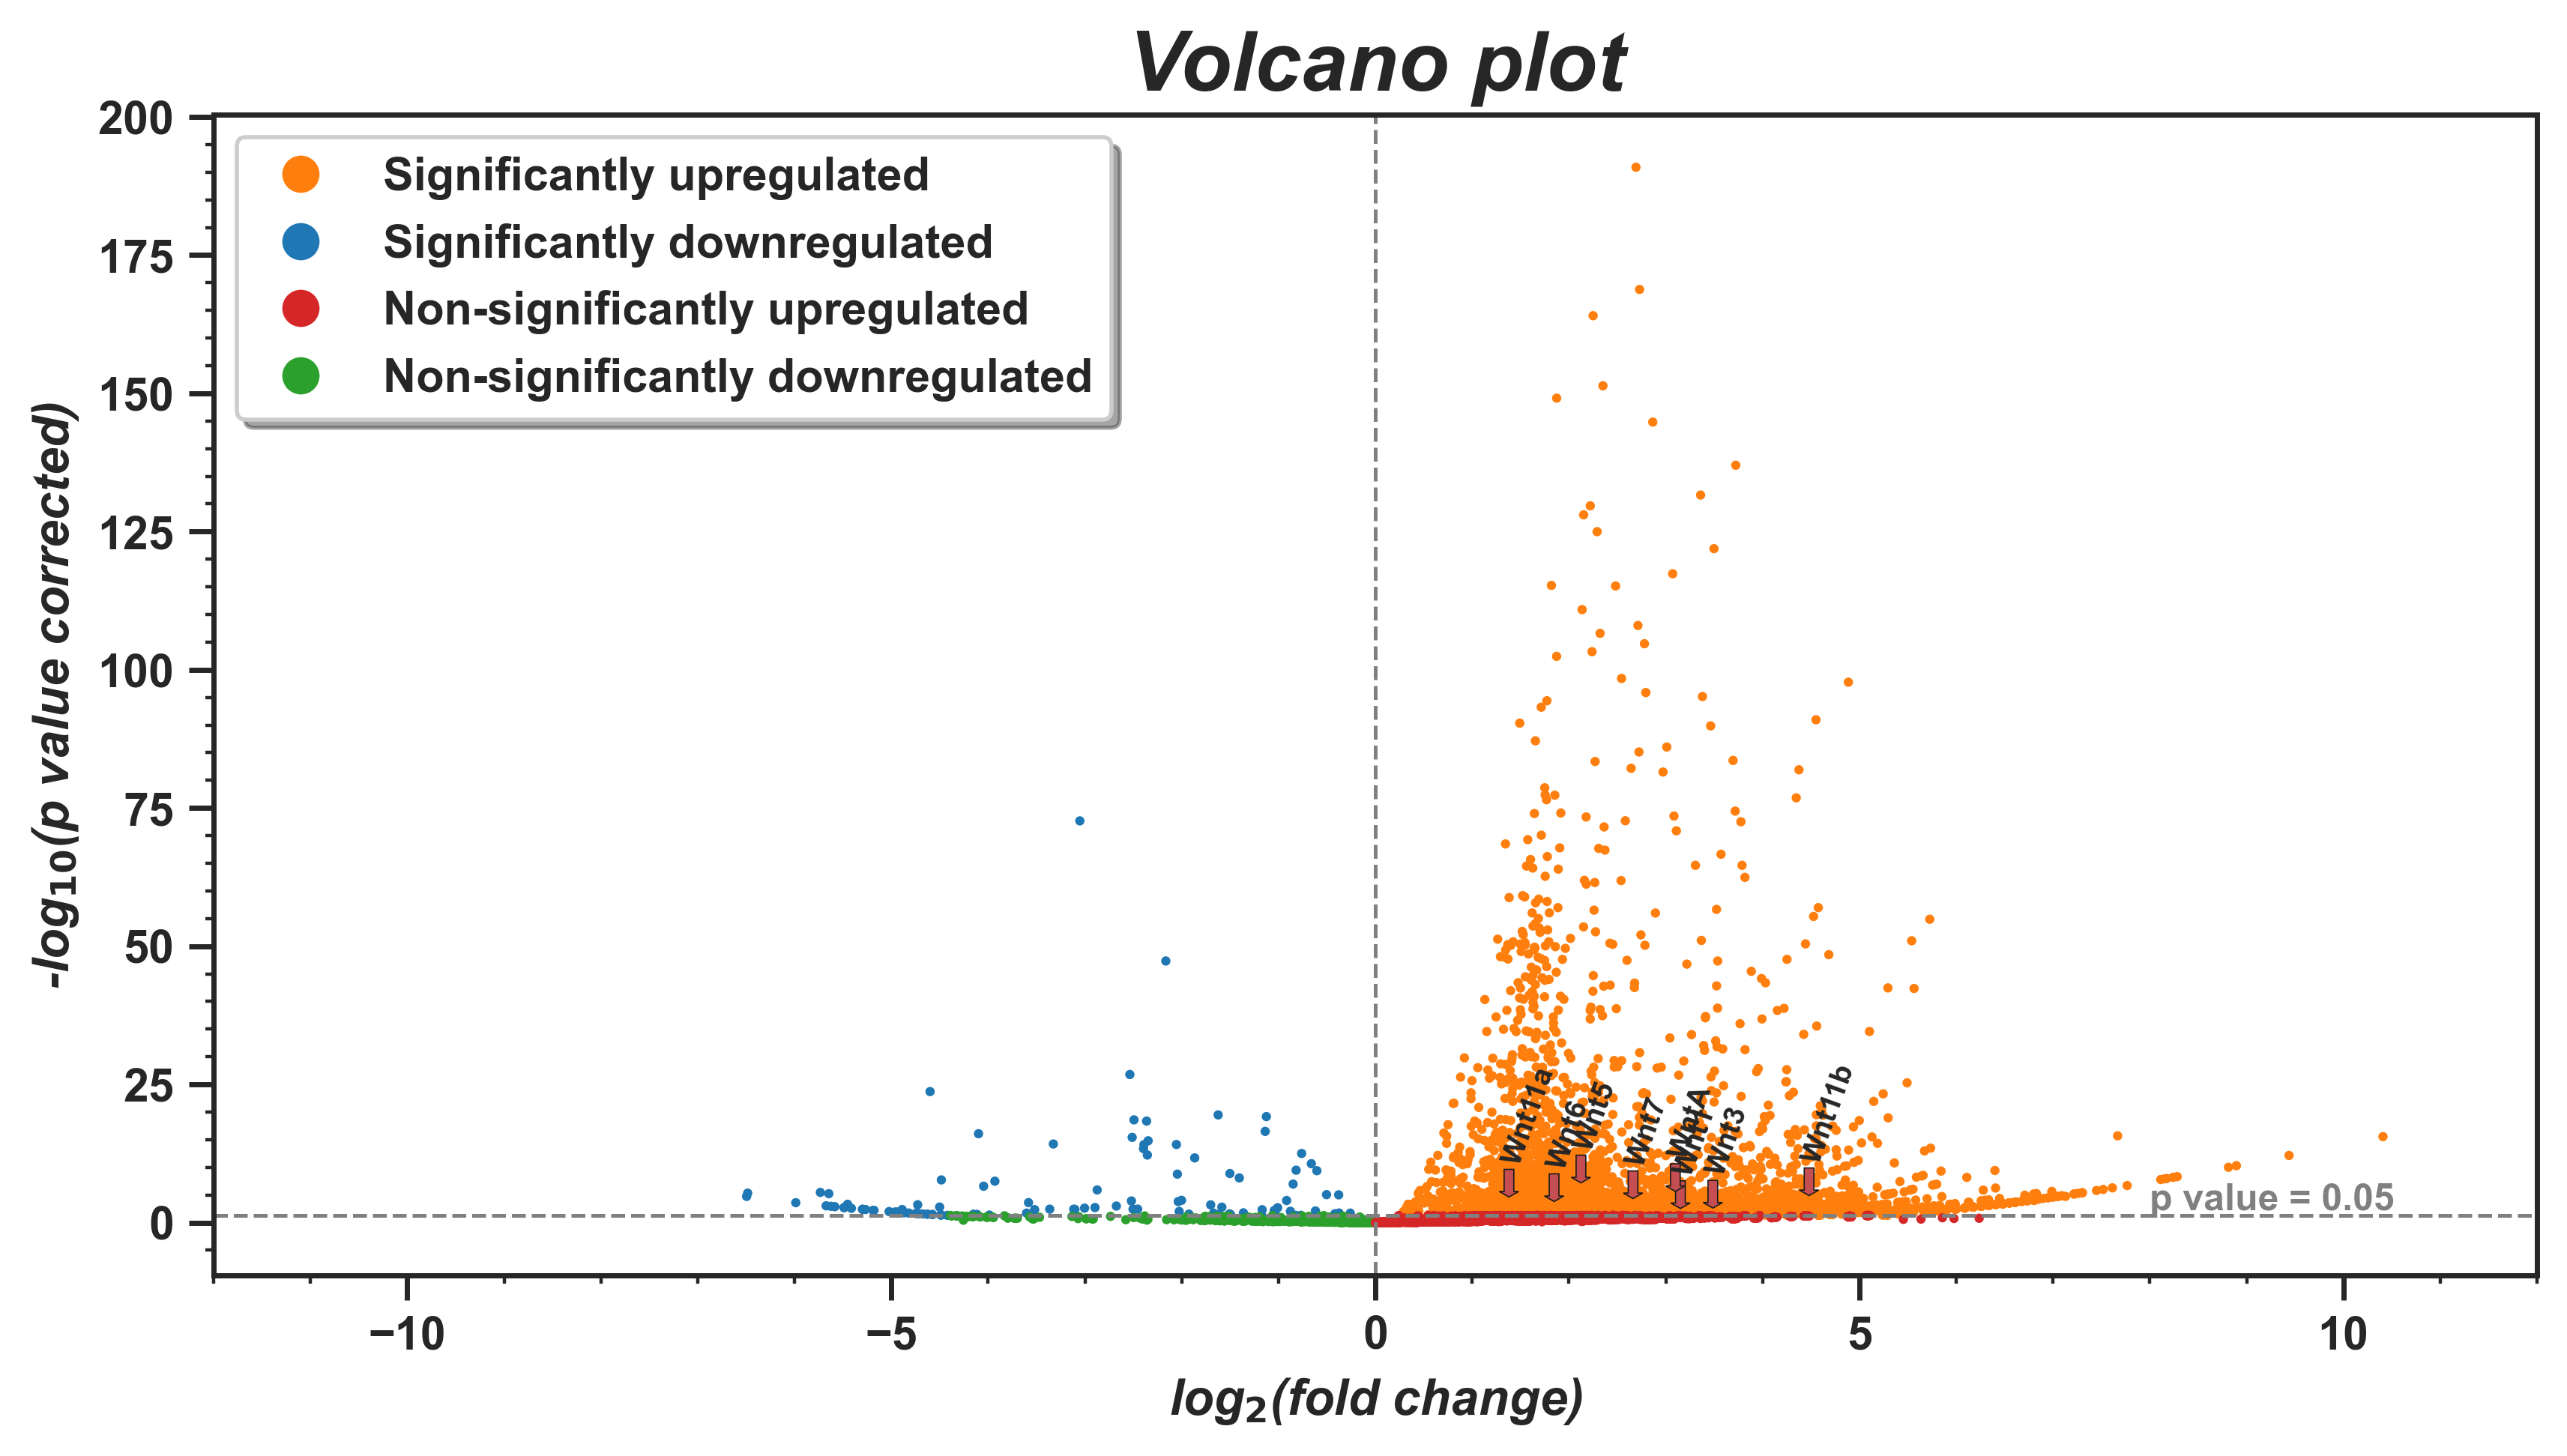

In [97]:
sns.set_theme(style="ticks", font='sans-serif', rc={'figure.figsize': (10, 5.03)})
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 3
plt.rcParams['font.weight'] = 'bold'

volcano = sns.scatterplot(data=volcano_deseq, x='log2FoldChange', y='log_padj', hue='expression_change', palette=palette, s=5, linewidth=0)

arrow_vshift = 6
text_vshift = arrow_vshift + 1.3
text_hshift = -0.1

for i, row in volcano_deseq.loc[wnt_deseq_df.index].iterrows():
    plt.text(row['log2FoldChange'] + text_hshift, row['log_padj'] + text_vshift, wnt_deseq_df.at[i, 'wnt_name'], 
             rotation=70, fontfamily='sans-serif', size=7, weight='extra bold')
    plt.arrow(row['log2FoldChange'], row['log_padj'] + arrow_vshift, dx=0, dy=-arrow_vshift+2,
              head_width=0.2, head_length=1, width=0.1, linewidth=0.3, fc='r', ec='k')

plt.text(8, -np.log10(0.05) + 1, 'p value = 0.05', c='grey', fontfamily='sans-serif', size=9, weight='bold')
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--', linewidth=0.9)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.9)

xlim = int(np.ceil(volcano_deseq.log2FoldChange.abs().max())) + 1
plt.xlim(-xlim, xlim)
volcano.set_xticks(np.linspace(-xlim, xlim, xlim*2 + 1), minor=True)

y_prec = 5
ymin = int(y_prec * np.floor(volcano_deseq.log_padj.min() / y_prec - 1))
ymax = int(y_prec * np.floor(volcano_deseq.log_padj.max() / y_prec + 1))
volcano.set_yticks(np.linspace(ymin, ymax, int((ymax - ymin)/y_prec) + 1), minor=True)

volcano.tick_params(which='minor', length=2, width=0.8)
volcano.set_title('Volcano plot', weight='black', style='italic', fontsize=20)
volcano.set_xlabel('log$_2$(fold change)', weight='black', style='italic')
volcano.set_ylabel('-log$_{10}$(p value corrected)', weight='black', style='italic')

plt.legend(shadow=True, title=None, markerscale=4)
# plt.savefig('../data_folder/processed_data/4.Expression_count/kallisto/dynamena_volcano.png', dpi=300)
plt.show()

### Wnt in tip

In [98]:
with OpenFasta(r'../data_folder/raw_data/reads/Wnt/Dynamena verhushka.txt') as fasta:
    for record in fasta:
        if record.rec_id in deseq_results_lfc_pos.index:
            print(record.rec_id)
        elif record.rec_id in deseq_results_lfc_neg.index:
            print(record.rec_id)

NODE_30596_length_2176_cov_77.946085_g7726_i0
NODE_23411_length_2643_cov_202.934231_g3665_i1
NODE_35311_length_1912_cov_381.418406_g9106_i0
NODE_15098_length_3408_cov_801.676077_g2110_i3
NODE_31634_length_2114_cov_563.558184_g7619_i1
NODE_16441_length_3255_cov_462.235679_g3985_i1


In [99]:
wnt_tip_deseq, wnt_tip_name = [], []
with OpenFasta(r'../data_folder/raw_data/reads/Wnt/Dynamena verhushka.txt') as fasta:
    for record in fasta:
        if record.rec_id in deseq_results_lfc_pos.index:
            wnt_tip_deseq.append(deseq_results_ctrl.loc[record.rec_id])
            wnt_tip_name.append(record.rec_desc)
        elif record.rec_id in deseq_results_lfc_neg.index:
            wnt_tip_deseq.append(deseq_results_ctrl.loc[record.rec_id])
            wnt_tip_name.append(record.rec_desc)
wnt_tip_deseq_df = pd.DataFrame(wnt_tip_deseq)
wnt_tip_deseq_df['wnt_tip_name'] = wnt_tip_name

In [100]:
wnt_tip_deseq_df

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,wnt_tip_name
NODE_30596_length_2176_cov_77.946085_g7726_i0,NODE_30596_length_2176_cov_77.946085_g7726_i0,11.67,3.13,0.80,3.90,0.00,0.00,Notum
NODE_23411_length_2643_cov_202.934231_g3665_i1,NODE_23411_length_2643_cov_202.934231_g3665_i1,35.95,2.23,0.43,5.17,0.00,0.00,Bra1
NODE_35311_length_1912_cov_381.418406_g9106_i0,NODE_35311_length_1912_cov_381.418406_g9106_i0,45.53,1.23,0.37,3.32,0.00,0.00,Bra2
NODE_15098_length_3408_cov_801.676077_g2110_i3,NODE_15098_length_3408_cov_801.676077_g2110_i3,48.71,2.84,0.39,7.19,0.00,0.00,b-catenin
NODE_31634_length_2114_cov_563.558184_g7619_i1,NODE_31634_length_2114_cov_563.558184_g7619_i1,64.21,1.26,0.32,3.97,0.00,0.00,TCF
NODE_16441_length_3255_cov_462.235679_g3985_i1,NODE_16441_length_3255_cov_462.235679_g3985_i1,13.53,2.98,0.74,4.03,0.00,0.00,Axin


# Snakefile

In [58]:
%%writefile Snakefile
dir_data='raw_data'
dir_ref, dir_reads, dir_control = 'reference', 'reads', 'control'
dir_fastqc='fastqc'

DIR_DICT={'reference': f'{dir_data}/{dir_ref}/',
          'reads': f'{dir_data}/{dir_reads}/',
          'control': f'{dir_data}/{dir_control}/'}
NAMES_DICT={'reference': ['new_dyn_soft_filtered_transcripts.fasta'],
          'reads': ['Primary_polyp_AZK_1_GAGTGGAT_L002_R1_001.fastq.bz2', 'Primary_polyp_AZK_2_ACTGATAT_L002_R1_001.fastq.bz2', 'Primary_polyp_AZK_3_ATTCCTTT_L002_R1_001.fastq.bz2'],
          'control':['Primary_polyp_DMSO_1_GTGGCCTT_L002_R1_001.fastq.bz2', 'Primary_polyp_DMSO_2_GTTTCGGA_L002_R1_001.fastq.bz2', 'Primary_polyp_DMSO_3_CGTACGTA_L002_R1_001.fastq.bz2']}

make_sorting=True

# rule reads_download:
#     output:
#         "{dir1}/{sample}-{n}.fastq.gz"
#     params:
#         URL=lambda wcs: URL_DICT[wcs.sample][int(wcs.n) - 1]  # https://stackoverflow.com/a/56043556
#     shell:
#         "wget -O {output} {params.URL}"

# rule reference_download:
#     output:
#         "{reference}.fasta"
#     shell:
#         "efetch -db nucleotide -id KF848938.1 -format fasta > {wildcards.reference}.fasta"

# rule reference_uzip:
#     input:
#         "{reference}.fasta.gz"
#     output:
#         "{reference}.fasta"
#     shell:
#         "gunzip -c {input} > {output}"

rule reads_unzip:
    output:
        '{dir_data}/{dir_reads}/{sample}-{n}.fastq'
    params:
        FILE=lambda wcs: NAMES_DICT[wcs.sample][int(wcs.n) - 1]  # https://stackoverflow.com/a/56043556
    shell:
        'bzip2 -vcfdk {wildcards.dir_data}/{wildcards.dir_reads}/{params.FILE} > {output}'

rule inspect_quality:
    input:
        rules.reads_unzip.output
    output:
        "{dir_fastqc}/{sample}-{n}_fastqc.html",
        "{dir_fastqc}/{sample}-{n}_fastqc.zip"
    shell:
        "fastqc -o ./{wildcards.dir_fastqc} -t 16 {input}"

# rule bwa_index:
#     input:
#         "{reference}.fasta"
#     log:
#         "logs/bwa_logs/bwa_index_{reference}.log"
#     output:
#         "{reference}.fasta.amb",
#         "{reference}.fasta.ann",
#         "{reference}.fasta.bwt",
#         "{reference}.fasta.pac",
#         "{reference}.fasta.sa"
#     shell:
#         "bwa index {input} &> {log}"
        
# rule bwa_align:
#     input:        
#         rules.bwa_index.output,
#         ref="{reference}.fasta",
#         reads=lambda wcs: "{dir}/{{sample}}-{{n}}.fastq.gz".format(dir=DIR_DICT.get(wcs.sample, "reads"))  # https://stackoverflow.com/a/67944385
#     threads: 8
#     params:
#         readgroup=r"@RG\tID:1\tSM:{sample}-{n}\tPL:illumina"
#     log:
#         bwa_log="logs/bwa_logs/bwa_sort_{reference}_{sample}-{n}.log",
#         smt_log="logs/flagstat_{reference}_{sample}-{n}.log"
#     output:
#         "{reference}_{sample}-{n}_unsorted.bam"
#     shell:
#         "bwa mem -t {threads} -R '{params.readgroup}' {input.ref} {input.reads} 2> {log.bwa_log} | samtools view -S -b - | tee {output} | samtools flagstat - &> {log.smt_log}"
#         # 1. `samtools` нужно указывать `-` для входных данных, если они поступают из стандартного потока ввода, а не передаются файлом.
#         # 2. Чтобы перенаправить результат одновременно в и файл, и в стандартный поток вывода, нужно использовать команду `tee`.

# rule bam_sort:
#     input:
#         rules.bwa_align.output
#     output:
#         protected("{reference}_{sample}-{n}_sorted.bam")
#     threads: 8
#     shell:
#         "samtools sort --threads {threads} {input} > {output}"

# rule calculate_coverage:
#     input:
#         rules.bam_sort.output
#     output:
#         "logs/coverage_{reference}_{sample}-{n}.txt"
#     shell:
#         "samtools depth -a {input} > {output}"

# rule bam_index:
#     input:
#         rules.bam_sort.output
#     output:
#         "{reference}_{sample}-{n}_sorted.bam.bai"
#     threads: 8
#     shell:
#         "samtools index --threads {threads} {input} > {output}"

# rule variant_calling:
#     input:
#         bam=rules.bam_sort.output,
#         ref="{reference}.fasta"
#     log:
#         vr_log="logs/varscan_{reference}_{sample}-{n}_{freq}.log",
#         vr_res_parse="logs/varscan_{reference}_{sample}-{n}_{freq}_parse.txt"        
#     output:
#         "{reference}_{sample}-{n}_{freq}_VarScan_results.vcf"
#     shell:
#         """samtools mpileup -f {input.ref} {input.bam} -d 0 | varscan mpileup2snp --min-var-freq {wildcards.freq} --variants --output-vcf 1 1> >(tee {output}) 2> {log.vr_log} | awk 'NR>24 {{print $1, $2, $4, $5, $10}}' > {log.vr_res_parse}"""
#         # флаг -d 0 устанавливает количество обрабатываемых ридов для каждой позиции на максимальное значение 214748364: http://www.htslib.org/doc/samtools-mpileup.html#OPTIONS
#         # перенаправляем stdout и stderr в 2 разных файла: `1> {output} 2> {log}`
#         # используем [process substitution](https://stackoverflow.com/a/692407) чтобы передать в `tee` только stdout, а stderr перенаправить в лог: 1> >(tee {output}) 2> {log.vr_log}

# rule filter_awk_freq:
#     input:
#       "{reference}_{sample}-{n}_0.001_VarScan_results.vcf"
#     output:
#       "{reference}_{sample}-{n}_freq.csv"
#     shell:
#         """cat {input} | awk 'NR>24 {{print $10}}' | awk 'BEGIN {{FS=":";}}{{print $7}}' | awk -F'\t' -v OFS='\t' 'NR == 0 {{print $0; next}}{{print (NR), $0}}' > {output}"""
        
# rule filter_awk_01:
#     input:
#       "{reference}_{sample}-{n}_0.001_VarScan_results.vcf"
#     output:
#       "{reference}_{sample}-{n}_variants_01.csv"
#     shell:
#         """cat {input} | awk 'NR>24 {{print $1, $2, $4, $5}}' | awk -F'\t' -v OFS='\t' 'NR == 0 {{print $0; next}}{{print (NR), $0}}' > {output}"""

# rule merge:
#     input:
#       file1 = rules.filter_awk_01.output,
#       file2 = rules.filter_awk_freq.output
#     output:
#       "{reference}_{sample}-{n}_merge.csv"
#     shell:
#         """join {input.file1} {input.file2} | awk '{{sub("%", "", $6) ; print}}' > {output}"""

Overwriting Snakefile


#### 1. Inspect the data from your roommate

In [ ]:
%%bash
snakemake --cores=all -p reads/target-1.fastq.gz

#####  Inspect reads with FastQC

In [ ]:
%%bash
snakemake --cores=all -p reads/fastqc/target-1_fastqc.html

#### 2. Align your roommate’s data to the reference sequence

##### 2.1 Index the reference file

In [ ]:
%%bash
snakemake --cores=all -p KF848938.1.fasta.amb

##### 2.2 Align your reads and compress SAM file

In [ ]:
%%bash
snakemake --cores=all -p KF848938.1_target-1_unsorted.bam

##### 2.3. Sort BAM file

In [ ]:
%%bash
snakemake --cores=all -p KF848938.1_target-1_sorted.bam

##### 2.4. Index BAM file

In [ ]:
%%bash
snakemake --cores=all -p KF848938.1_target-1_sorted.bam.bai